
--- Training DDQN Agent with Shaped Rewards (Deterministic Environment) ---


Training DDQN Agent: 100%|██████████| 10000/10000 [02:54<00:00, 57.38it/s]



DDQN Results (Deterministic, Shaped):
  Variance: 0.1475, Sample Efficiency (90% peak avg): -1 episodes, Time/Episode: 0.0174s

--- Training Classical TD and Monte Carlo Agents on Slippery FrozenLake ---


MC First Visit: 100%|██████████| 5000/5000 [00:04<00:00, 1198.45it/s]



MC First Visit Results (Slippery, Original Rewards):
  Variance: 0.0000, Sample Efficiency (90% peak avg): 0 episodes, Time/Episode: 0.0008s


MC Every Visit: 100%|██████████| 5000/5000 [03:19<00:00, 25.11it/s]



MC Every Visit Results (Slippery, Original Rewards):
  Variance: 0.0000, Sample Efficiency (90% peak avg): 0 episodes, Time/Episode: 0.0397s


TD(0) Q-Learning: 100%|██████████| 5000/5000 [00:03<00:00, 1401.33it/s]



TD(0) Q-Learning Results (Slippery, Original Rewards):
  Variance: 0.0000, Sample Efficiency (90% peak avg): 0 episodes, Time/Episode: 0.0007s


TD(lambda) SARSA: 100%|██████████| 5000/5000 [00:23<00:00, 209.05it/s]



TD(lambda) SARSA Results (Slippery, Original Rewards):
  Variance: 0.0000, Sample Efficiency (90% peak avg): 0 episodes, Time/Episode: 0.0048s


TD(lambda) Q-Learning: 100%|██████████| 5000/5000 [00:24<00:00, 203.66it/s]



TD(lambda) Q-Learning Results (Slippery, Original Rewards):
  Variance: 0.0000, Sample Efficiency (90% peak avg): 0 episodes, Time/Episode: 0.0049s


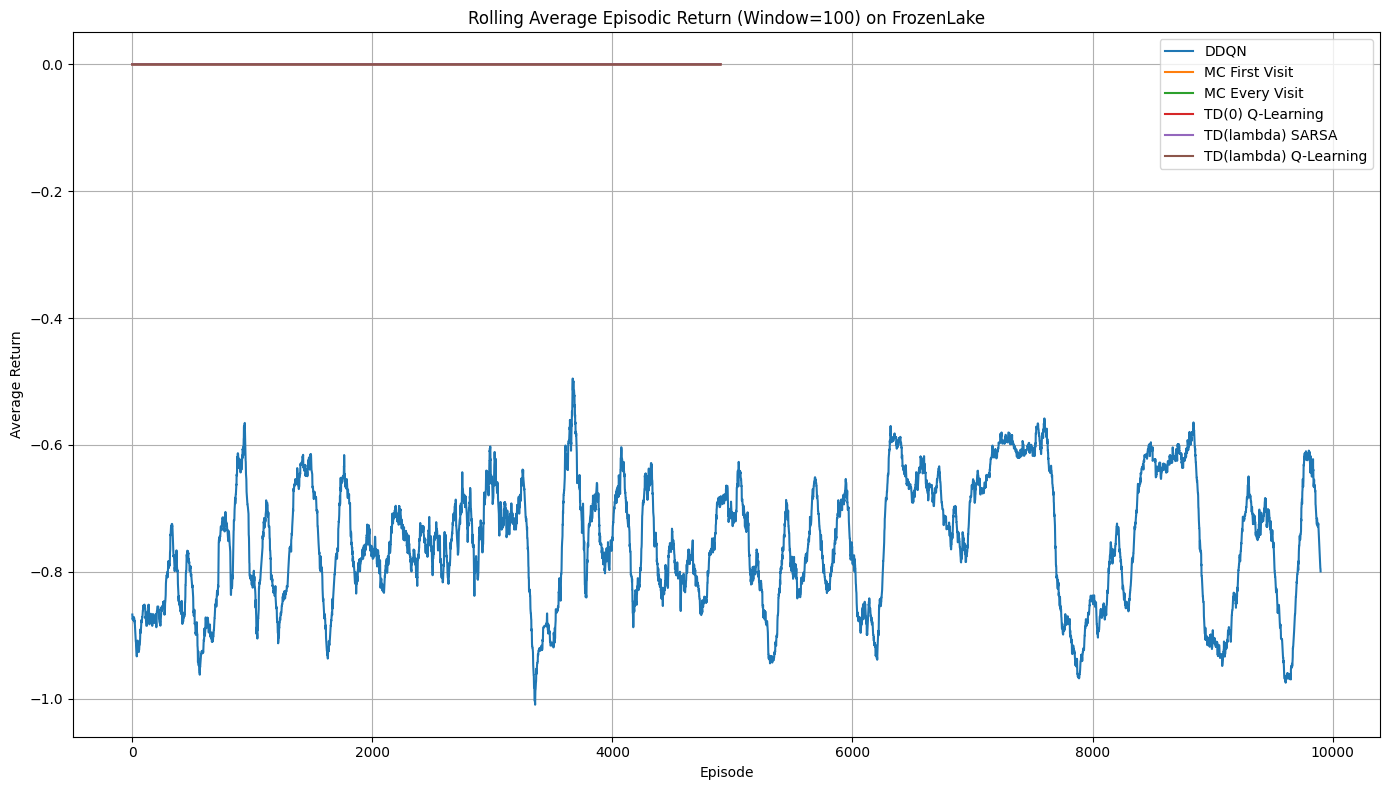

In [6]:
# === MERGED FROZENLAKE RL AGENTS: CLASSICAL & DDQN ===

# --- Standard Library Imports ---
import time
import random
from collections import defaultdict

# --- Third-Party Library Imports ---
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim

# ==============================================================================
# === HELPER FUNCTIONS ===
# ==============================================================================

def plot_metric(metric_values, label, window=100):
    """
    Plots the rolling average of a given metric over episodes.

    Args:
        metric_values (list or np.array): List of metric values per episode (e.g., rewards).
        label (str): Label for the plot line.
        window (int): The size of the rolling window for averaging.
    """
    if len(metric_values) < window:
        print(f"Warning: Not enough data points ({len(metric_values)}) for a window of {window}. Plotting raw values.")
        plt.plot(metric_values, label=label)
        return

    # Calculate the rolling average using convolution.
    # np.ones(window)/window creates a kernel for averaging.
    # mode='valid' ensures that the output has a size that doesn't include partial windows.
    rolling_avg = np.convolve(metric_values, np.ones(window)/window, mode='valid')
    plt.plot(rolling_avg, label=label)

def evaluate_agent(rewards, times):
    """
    Evaluates the performance of an RL agent based on collected rewards and times.

    Args:
        rewards (list): A list of total rewards obtained in each episode.
        times (list): A list of times taken for each episode.

    Returns:
        tuple: A tuple containing:
            - variance (float): Variance of the rewards.
            - sample_eff (int): Sample efficiency (episode number to reach 90% of max rolling avg).
            - avg_time (float): Average time taken per episode.
    """
    rewards_np = np.array(rewards)
    
    if len(rewards_np) < 100: # Need at least 100 episodes for rolling average
        # Handle cases with too few episodes for meaningful rolling avg calculation
        variance = np.var(rewards_np) if len(rewards_np) > 1 else 0.0
        sample_eff = -1 # Cannot determine
        max_avg = np.mean(rewards_np) # Use mean of all rewards
    else:
        variance = np.var(rewards_np)  # Calculate the variance of episode rewards.
        # Calculate the rolling average of rewards to find the maximum average.
        rolling_avg = np.convolve(rewards_np, np.ones(100)/100, mode='valid')
        max_avg = np.max(rolling_avg)
        
        # Find the first episode index where the rolling average reaches at least 90% of the maximum average.
        # This serves as a proxy for sample efficiency. Returns -1 if not found.
        sample_eff = next((i for i, avg in enumerate(rolling_avg) if avg >= 0.9 * max_avg), -1)

    avg_time = np.mean(times) if len(times) > 0 else 0.0  # Calculate the average time per episode.
    return variance, sample_eff, avg_time

# ==============================================================================
# === ENVIRONMENT WRAPPERS ===
# ==============================================================================

class ShapedFrozenLakeWrapper(gym.Wrapper):
    """
    A custom Gymnasium wrapper for the FrozenLake environment that modifies the reward structure.
    It introduces shaped rewards to guide the agent's learning process,
    penalizing steps and falls into holes, and rewarding reaching the goal.
    """
    def __init__(self, env):
        """
        Initializes the wrapper with the base environment.

        Args:
            env (gym.Env): The base FrozenLake environment.
        """
        super().__init__(env)

    def step(self, action):
        """
        Performs a step in the environment and applies reward shaping.

        Args:
            action (int): The action taken by the agent.

        Returns:
            tuple: (obs, shaped_reward, terminated, truncated, info)
                   - obs (object): The new observation of the environment.
                   - shaped_reward (float): The modified reward.
                   - terminated (bool): Whether the episode has ended due to termination.
                   - truncated (bool): Whether the episode has ended due to truncation.
                   - info (dict): Additional information from the environment.
        """
        obs, reward, terminated, truncated, info = self.env.step(action)

        # Start with a small negative reward per step to encourage shorter paths
        shaped_reward = -0.01
        
        # Get the current tile type to determine specific reward shaping
        # This assumes a FrozenLake environment with `unwrapped.desc` and `unwrapped.s`
        try:
            desc = self.unwrapped.desc.tolist()
            row, col = self.unwrapped.s // self.unwrapped.ncol, self.unwrapped.s % self.unwrapped.ncol
            current_tile = desc[row][col].decode("utf-8")
        except AttributeError:
            # Fallback for environments that might not have these attributes or if unwrapped fails
            current_tile = '' # Cannot determine tile type without specific env attributes

        # Check what happened at the end of the episode
        if terminated:
            if reward == 1.0: # Original environment's goal reward
                shaped_reward = 1.0  # High reward for reaching the goal
            elif current_tile == 'H':
                shaped_reward = -0.5  # Significant penalty for falling in a hole
            elif 'is_success' in info and not info['is_success']:
                # Generic check for failure in terminated state if no 'H'
                shaped_reward = -0.5 # General penalty for failing to reach goal when terminated
        # else: shaped_reward remains -0.01 per step

        return obs, shaped_reward, terminated, truncated, info

# ==============================================================================
# === CLASSICAL TABULAR RL AGENTS ===
# ==============================================================================

def mc_first_visit(env, episodes=5000, gamma=0.99, epsilon=0.1):
    """
    Implements the Monte Carlo First-Visit Control algorithm.

    Args:
        env (gym.Env): The Gymnasium environment.
        episodes (int): The total number of episodes to train for.
        gamma (float): Discount factor.
        epsilon (float): Epsilon for epsilon-greedy policy.

    Returns:
        tuple: A tuple containing:
            - Q (defaultdict): The learned Q-value function.
            - rewards_per_episode (list): Total rewards obtained in each episode.
            - times_per_episode (list): Time taken for each episode.
    """
    # Q-table to store state-action values. Initialized to zeros.
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # Stores all returns for each state-action pair to calculate averages.
    returns = defaultdict(list)
    rewards_per_episode = []
    times_per_episode = []

    for _ in tqdm(range(episodes), desc="MC First Visit"):
        start = time.time()
        state, _ = env.reset()  # Reset environment for a new episode.
        episode = []  # To store (state, action, reward) tuples for the current episode.
        done = False

        # Generate an episode
        while not done:
            # Epsilon-greedy policy to choose an action.
            # Explore (random action) with probability epsilon, exploit (greedy action) otherwise.
            action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[state])
            next_state, reward, terminated, truncated, _ = env.step(action)
            episode.append((state, action, reward))
            state = next_state
            done = terminated or truncated

        G = 0  # Initialize return G.
        visited = set()  # To keep track of (state, action) pairs visited in this episode.
        
        # Iterate through the episode in reverse to calculate returns and update Q-values.
        for s, a, r in reversed(episode):
            G = gamma * G + r  # Calculate discounted return.
            if (s, a) not in visited:  # Only update for the first visit of (s, a) in the episode.
                visited.add((s, a))
                returns[(s, a)].append(G)  # Add the return to the list for this (s, a) pair.
                Q[s][a] = np.mean(returns[(s, a)])  # Update Q-value as the average of observed returns.

        rewards_per_episode.append(sum([x[2] for x in episode]))  # Sum of rewards for the episode.
        times_per_episode.append(time.time() - start)

    return Q, rewards_per_episode, times_per_episode

def mc_every_visit(env, episodes=5000, gamma=0.99, epsilon=0.1):
    """
    Implements the Monte Carlo Every-Visit Control algorithm.

    Args:
        env (gym.Env): The Gymnasium environment.
        episodes (int): The total number of episodes to train for.
        gamma (float): Discount factor.
        epsilon (float): Epsilon for epsilon-greedy policy.

    Returns:
        tuple: A tuple containing:
            - Q (defaultdict): The learned Q-value function.
            - rewards_per_episode (list): Total rewards obtained in each episode.
            - times_per_episode (list): Time taken for each episode.
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    returns = defaultdict(list)
    rewards_per_episode = []
    times_per_episode = []

    for _ in tqdm(range(episodes), desc="MC Every Visit"):
        start = time.time()
        state, _ = env.reset()
        episode = []
        done = False

        # Generate an episode
        while not done:
            action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[state])
            next_state, reward, terminated, truncated, _ = env.step(action)
            episode.append((state, action, reward))
            state = next_state
            done = terminated or truncated

        G = 0
        # Iterate through the episode in reverse.
        for i in reversed(range(len(episode))):
            s, a, r = episode[i]
            G = gamma * G + r  # Calculate discounted return.
            returns[(s, a)].append(G)  # Add the return for *every* visit of (s, a).
            Q[s][a] = np.mean(returns[(s, a)])  # Update Q-value as the average of all observed returns.

        rewards_per_episode.append(sum([x[2] for x in episode]))
        times_per_episode.append(time.time() - start)

    return Q, rewards_per_episode, times_per_episode

def td0_q_learning(env, episodes=5000, gamma=0.99, alpha=0.1, epsilon=0.1):
    """
    Implements the TD(0) Q-Learning algorithm.

    Args:
        env (gym.Env): The Gymnasium environment.
        episodes (int): The total number of episodes to train for.
        gamma (float): Discount factor.
        alpha (float): Learning rate.
        epsilon (float): Epsilon for epsilon-greedy policy.

    Returns:
        tuple: A tuple containing:
            - Q (defaultdict): The learned Q-value function.
            - rewards_per_episode (list): Total rewards obtained in each episode.
            - times_per_episode (list): Time taken for each episode.
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards_per_episode = []
    times_per_episode = []

    for _ in tqdm(range(episodes), desc="TD(0) Q-Learning"):
        start = time.time()
        state, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            # Choose action using epsilon-greedy policy.
            action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[state])
            next_state, reward, terminated, truncated, _ = env.step(action)
            
            # Q-learning is off-policy: it uses the greedy action for the next state's Q-value.
            # Max Q-value for next_state to estimate future return
            max_q_next = np.max(Q[next_state]) 
            
            # Q-value update rule: Q(s,a) = Q(s,a) + alpha * [reward + gamma * max_a' Q(s',a') - Q(s,a)]
            Q[state][action] += alpha * (reward + gamma * max_q_next - Q[state][action])
            
            state = next_state
            total_reward += reward
            done = terminated or truncated

        rewards_per_episode.append(total_reward)
        times_per_episode.append(time.time() - start)

    return Q, rewards_per_episode, times_per_episode

def td_lambda_sarsa(env, episodes=5000, gamma=0.99, alpha=0.1, lam=0.9, epsilon=0.1):
    """
    Implements the TD(lambda) SARSA algorithm with eligibility traces.

    Args:
        env (gym.Env): The Gymnasium environment.
        episodes (int): The total number of episodes to train for.
        gamma (float): Discount factor.
        alpha (float): Learning rate.
        lam (float): Lambda parameter for eligibility traces.
        epsilon (float): Epsilon for epsilon-greedy policy.

    Returns:
        tuple: A tuple containing:
            - Q (defaultdict): The learned Q-value function.
            - rewards_per_episode (list): Total rewards obtained in each episode.
            - times_per_episode (list): Time taken for each episode.
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards_per_episode = []
    times_per_episode = []

    for _ in tqdm(range(episodes), desc="TD(lambda) SARSA"):
        start = time.time()
        state, _ = env.reset()
        # Choose initial action using epsilon-greedy policy.
        action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[state])
        
        # Eligibility traces for (state, action) pairs.
        # Initialized to zero at the start of each episode.
        E = defaultdict(lambda: np.zeros(env.action_space.n))  
        total_reward = 0
        done = False

        while not done:
            next_state, reward, terminated, truncated, _ = env.step(action)
            # Choose next action using epsilon-greedy policy. This makes SARSA on-policy.
            next_action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[next_state])
            
            # TD Error: reward + gamma * Q(s',a') - Q(s,a)
            delta = reward + gamma * Q[next_state][next_action] - Q[state][action]
            
            # Increment eligibility trace for the current state-action pair.
            E[state][action] += 1
            
            # Update Q-values and eligibility traces for all visited state-action pairs.
            # Iterate through all known states in Q (states that have been visited).
            for s in Q:
                for a in range(env.action_space.n):
                    Q[s][a] += alpha * delta * E[s][a]
                    E[s][a] *= gamma * lam  # Decay eligibility trace.
            
            state = next_state
            action = next_action
            total_reward += reward
            done = terminated or truncated

        rewards_per_episode.append(total_reward)
        times_per_episode.append(time.time() - start)

    return Q, rewards_per_episode, times_per_episode

def td_lambda_q_learning(env, episodes=5000, gamma=0.99, alpha=0.1, lam=0.9, epsilon=0.1):
    """
    Implements the TD(lambda) Q-Learning algorithm with eligibility traces.

    Args:
        env (gym.Env): The Gymnasium environment.
        episodes (int): The total number of episodes to train for.
        gamma (float): Discount factor.
        alpha (float): Learning rate.
        lam (float): Lambda parameter for eligibility traces.
        epsilon (float): Epsilon for epsilon-greedy policy.

    Returns:
        tuple: A tuple containing:
            - Q (defaultdict): The learned Q-value function.
            - rewards_per_episode (list): Total rewards obtained in each episode.
            - times_per_episode (list): Time taken for each episode.
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards_per_episode = []
    times_per_episode = []

    for _ in tqdm(range(episodes), desc="TD(lambda) Q-Learning"):
        start = time.time()
        state, _ = env.reset()
        # Eligibility traces for (state, action) pairs.
        E = defaultdict(lambda: np.zeros(env.action_space.n))  
        total_reward = 0
        done = False

        while not done:
            # Choose action using epsilon-greedy policy.
            action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[state])
            next_state, reward, terminated, truncated, _ = env.step(action)
            
            # Q-learning is off-policy: it uses the greedy action for the next state's Q-value.
            # Max Q-value for next_state to estimate future return
            max_q_next = np.max(Q[next_state]) 
            
            # TD Error: reward + gamma * max_a' Q(s',a') - Q(s,a)
            delta = reward + gamma * max_q_next - Q[state][action]
            
            # Increment eligibility trace for the current state-action pair.
            E[state][action] += 1
            
            # Update Q-values and eligibility traces for all visited state-action pairs.
            for s in Q: # Iterate through all known states in Q
                for a in range(env.action_space.n):
                    Q[s][a] += alpha * delta * E[s][a]
                    E[s][a] *= gamma * lam  # Decay eligibility trace.
            
            state = next_state
            total_reward += reward
            done = terminated or truncated

        rewards_per_episode.append(total_reward)
        times_per_episode.append(time.time() - start)

    return Q, rewards_per_episode, times_per_episode

# ==============================================================================
# === DEEP REINFORCEMENT LEARNING AGENTS (DDQN) ===
# ==============================================================================

class DDQN(nn.Module):
    """
    The Deep Q-Network (DQN) architecture.
    It's a simple feed-forward neural network that takes a state as input
    and outputs Q-values for each possible action.
    """
    def __init__(self, state_dim, action_dim):
        """
        Initializes the DDQN neural network.

        Args:
            state_dim (int): The dimension of the input state.
            action_dim (int): The number of possible actions (output dimension).
        """
        super().__init__()
        # Define a sequential neural network with one hidden layer.
        self.net = nn.Sequential(
            nn.Linear(state_dim, 64),  # Input layer to hidden layer
            nn.ReLU(),                 # ReLU activation function
            nn.Linear(64, action_dim)  # Hidden layer to output layer (Q-values for each action)
        )

    def forward(self, x):
        """
        Performs a forward pass through the network.

        Args:
            x (torch.Tensor): The input state tensor.

        Returns:
            torch.Tensor: The output Q-values for each action.
        """
        return self.net(x)

class DDQNAgent:
    """
    Implements a Double Deep Q-Network (DDQN) agent.
    DDQN uses two neural networks (Q-network and Target network) to stabilize training,
    and incorporates experience replay and epsilon-greedy exploration.
    """
    def __init__(self, env, gamma=0.99, lr=1e-3, memory_capacity=10000, batch_size=32, update_freq=50):
        """
        Initializes the DDQN Agent.

        Args:
            env (gym.Env): The environment the agent will interact with.
            gamma (float): Discount factor for future rewards.
            lr (float): Learning rate for the optimizer.
            memory_capacity (int): Maximum size of the experience replay memory.
            batch_size (int): Number of transitions to sample for each learning step.
            update_freq (int): How often to update the target network (every 'update_freq' learning steps).
        """
        self.env = env
        self.gamma = gamma
        self.epsilon = 1.0  # Initial exploration rate
        self.epsilon_decay = 0.9995  # Rate at which epsilon decays
        self.epsilon_min = 0.05     # Minimum exploration rate
        
        # Determine the device (CPU or GPU) for PyTorch operations
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Assuming a discrete state space where state can be directly used as input.
        # For FrozenLake (integers 0-63), we will treat it as a single scalar input.
        state_dim = 1 
        action_dim = env.action_space.n

        # Main Q-network: used for action selection and learning
        self.q_net = DDQN(state_dim, action_dim).to(self.device)
        # Target Q-network: a copy of the Q-network used to compute target Q-values
        # This helps stabilize training by providing a fixed target for some time.
        self.target_net = DDQN(state_dim, action_dim).to(self.device)
        # Initialize target network with the same weights as the main Q-network
        self.target_net.load_state_dict(self.q_net.state_dict())

        # Optimizer for updating Q-network weights
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        # Loss function for computing the difference between predicted and target Q-values
        self.criteria = nn.MSELoss() # Mean Squared Error Loss

        # Experience replay buffer: stores (state, action, reward, next_state, done) transitions
        self.memory = []
        self.memory_capacity = memory_capacity
        self.batch_size = batch_size
        self.update_freq = update_freq
        self.learn_step = 0   # Counter for learning steps

    def act(self, state):
        """
        Selects an action using an epsilon-greedy policy.

        Args:
            state (int): The current state observation (an integer in FrozenLake).

        Returns:
            int: The chosen action.
        """
        # Epsilon-greedy action selection:
        # With probability epsilon, choose a random action (exploration).
        # Otherwise, choose the action with the highest Q-value from the Q-network (exploitation).
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        
        # Convert state to a PyTorch tensor, reshape it for the network, and move to device.
        # .float() ensures it's a float32 tensor
        # .unsqueeze(0) adds a batch dimension (e.g., from scalar to [1])
        # .unsqueeze(0) again to make it [1, 1] for input to linear layer expecting [batch_size, state_dim]
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(self.device)
        
        # Disable gradient calculation for action selection (inference only).
        self.q_net.eval() # Set Q-network to evaluation mode (e.g., disables dropout)
        with torch.no_grad():
            # Get Q-values from the Q-network and select the action with the maximum Q-value.
            q_values = self.q_net(state_tensor)
        self.q_net.train() # Set Q-network back to training mode
        return torch.argmax(q_values).item()

    def remember(self, transition):
        """
        Stores a new transition in the experience replay memory.

        Args:
            transition (tuple): A tuple (state, action, reward, next_state, done).
        """
        self.memory.append(transition)
        # Limit the memory size to avoid excessive memory usage.
        if len(self.memory) > self.memory_capacity:
            self.memory.pop(0) # Remove the oldest transition if memory is full.

    def learn(self):
        """
        Performs one learning step using a batch of experiences from the replay memory.
        This involves computing the TD target, calculating the loss, and updating the Q-network.
        It also periodically updates the target network and decays epsilon.
        """
        # Do not learn if there aren't enough samples in memory for a full batch.
        if len(self.memory) < self.batch_size:
            return

        # Sample a random batch of transitions from the replay memory.
        batch = random.sample(self.memory, self.batch_size)
        # Unzip the batch into separate lists for states, actions, rewards, next_states, and dones.
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert lists of numpy arrays/ints to PyTorch tensors and move them to the device.
        # .float() for rewards, states, next_states. .long() for actions (for gather).
        # .unsqueeze(1) adds a dimension to match the output shape of the network (e.g., [batch_size, 1]).
        states = torch.tensor(states, dtype=torch.float32).unsqueeze(1).to(self.device)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(self.device)
        next_states = torch.tensor(next_states, dtype=torch.float32).unsqueeze(1).to(self.device)
        # 'dones' indicates if a state is terminal, so its Q-value should be 0.
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(self.device)

        # Compute Q-values predicted by the main Q-network for the taken actions.
        # .gather(1, actions) selects the Q-value for the specific action taken in each state.
        q_values = self.q_net(states).gather(1, actions)
        
        # Compute the target Q-values for the Double DQN algorithm.
        # It uses the main Q-network to select the best action in the next state (maximizes Q).
        # Then, it uses the target network to evaluate the Q-value of that selected action.
        # The `max(1)[1]` returns the indices of the max values.
        # `q_net(next_states).max(1)[1].unsqueeze(1)` selects the best action for next_states
        # `target_net(next_states).gather(1, ...)` gets the Q-value of that action from the target net.
        next_state_actions = self.q_net(next_states).max(1)[1].unsqueeze(1) # Action chosen by Q-net for next state
        next_q_target = self.target_net(next_states).gather(1, next_state_actions).detach() # Q-value from target net

        # The Q-learning target: R + gamma * Q_target(S', argmax_a Q_main(S', a))
        # (1 - dones) handles terminal states: if done, the future reward term is zero.
        q_target = rewards + (1 - dones) * self.gamma * next_q_target

        # Calculate the Mean Squared Error loss between the predicted Q-values and the target Q-values.
        loss = self.criteria(q_values, q_target)
        
        # Zero the gradients, perform backpropagation, and update the Q-network weights.
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Periodically update the target network by copying the weights from the main Q-network.
        self.learn_step += 1
        if self.learn_step % self.update_freq == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())

        # Decay epsilon to reduce exploration over time.
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

# ==============================================================================
# === GENERAL TRAINING LOOP ===
# ==============================================================================

def train_agent(env, agent, episodes=5000):
    """
    General training loop for an RL agent. This function is designed to work
    with both tabular agents (which might have their own integrated training logic
    if passed directly) and DDQNAgent (which uses remember/learn methods).

    Args:
        env (gym.Env): The environment to train in.
        agent (callable or DDQNAgent): If callable (like MC/TD functions), it's called directly.
                                        If DDQNAgent, its act/remember/learn methods are used.
        episodes (int): The number of episodes to run for training.

    Returns:
        tuple: (rewards_per_episode, times_per_episode)
               - rewards_per_episode (list): A list of total rewards obtained in each episode.
               - times_per_episode (list): A list of times taken for each episode.
    """
    if isinstance(agent, DDQNAgent):
        # Specific training logic for DDQNAgent (using its act/remember/learn methods)
        rewards_per_episode = [] 
        times_per_episode = []
        for ep in tqdm(range(episodes), desc=f"Training DDQN Agent"):
            start_time = time.time()
            state, _ = env.reset()
            total_reward = 0
            done = False

            while not done:
                action = agent.act(state)
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated

                agent.remember((state, action, reward, next_state, done))
                agent.learn() # DDQN agent learns from a batch.

                total_reward += reward
                state = next_state
            
            rewards_per_episode.append(total_reward)
            times_per_episode.append(time.time() - start_time)
        return rewards_per_episode, times_per_episode

    else:
        # Assumes `agent` is a function (like mc_first_visit, td0_q_learning)
        # that encapsulates its own training loop and returns Q, rewards, times.
        # We only need rewards and times from it here.
        Q_table, rewards_per_episode, times_per_episode = agent(env, episodes=episodes)
        return rewards_per_episode, times_per_episode

# ==============================================================================
# === MAIN EXECUTION FOR ALL FROZENLAKE AGENTS ===
# ==============================================================================

if __name__ == "__main__":
    plt.figure(figsize=(14, 8)) # Create a single figure for all plots

    # --- Configuration for DDQN Agent ---
    print("\n--- Training DDQN Agent with Shaped Rewards (Deterministic Environment) ---")
    # DDQN benefits from a deterministic environment and shaped rewards for stability and faster learning
    ddqn_env = ShapedFrozenLakeWrapper(gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False, render_mode=None))
    # CORRECTED: Removed 'episodes' from DDQNAgent.__init__() call
    ddqn_agent = DDQNAgent(ddqn_env, lr=5e-4, memory_capacity=20000, batch_size=64, update_freq=100) 
    ddqn_rewards, ddqn_times = train_agent(ddqn_env, ddqn_agent, episodes=10000) # 'episodes' passed to train_agent
    
    # Evaluate and plot DDQN results (this is the line that generates the DDQN rolling average plot)
    ddqn_var, ddqn_eff, ddqn_avg_time = evaluate_agent(ddqn_rewards, ddqn_times)
    plot_metric(ddqn_rewards, "DDQN") 
    print(f"\nDDQN Results (Deterministic, Shaped):\n  Variance: {ddqn_var:.4f}, Sample Efficiency (90% peak avg): {ddqn_eff} episodes, Time/Episode: {ddqn_avg_time:.4f}s")
    
    # Close DDQN environment
    ddqn_env.close()

    # --- Configuration for Classical Tabular RL Agents ---
    print("\n--- Training Classical TD and Monte Carlo Agents on Slippery FrozenLake ---")
    # Classical tabular methods are often tested on the stochastic version
    classic_env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=True, render_mode=None)
    
    # Define a list of classical agents to train and evaluate
    # Note: These functions encapsulate their own training loop
    classical_agents_configs = [
        ("MC First Visit", mc_first_visit, 5000), # Agent function, number of episodes
        ("MC Every Visit", mc_every_visit, 5000),
        ("TD(0) Q-Learning", td0_q_learning, 5000),
        ("TD(lambda) SARSA", td_lambda_sarsa, 5000),
        ("TD(lambda) Q-Learning", td_lambda_q_learning, 5000)
    ]

    for name, agent_func, episodes_to_run in classical_agents_configs:
        # Call the agent function directly; it returns Q, rewards, and times
        Q_table, rewards, times = agent_func(classic_env, episodes=episodes_to_run)
        
        # Evaluate and plot results for the classical agent
        var, eff, avg_time = evaluate_agent(rewards, times)
        plot_metric(rewards, name)
        print(f"\n{name} Results (Slippery, Original Rewards):\n  Variance: {var:.4f}, Sample Efficiency (90% peak avg): {eff} episodes, Time/Episode: {avg_time:.4f}s")
    
    # Close classical environment
    classic_env.close()

    # --- Final Plot Settings ---
    plt.title("Rolling Average Episodic Return (Window=100) on FrozenLake")
    plt.xlabel("Episode")
    plt.ylabel("Average Return")
    plt.legend()  # Display legend with agent names
    plt.grid(True) # Add a grid to the plot
    plt.tight_layout() # Adjust plot to prevent labels from overlapping
    plt.show()    # Show the generated plot

#### Including Success Rate Evaluation


--- Training DDQN Agent with Shaped Rewards (Deterministic Environment) ---


Training DDQN Agent: 100%|██████████| 10000/10000 [02:31<00:00, 66.20it/s]


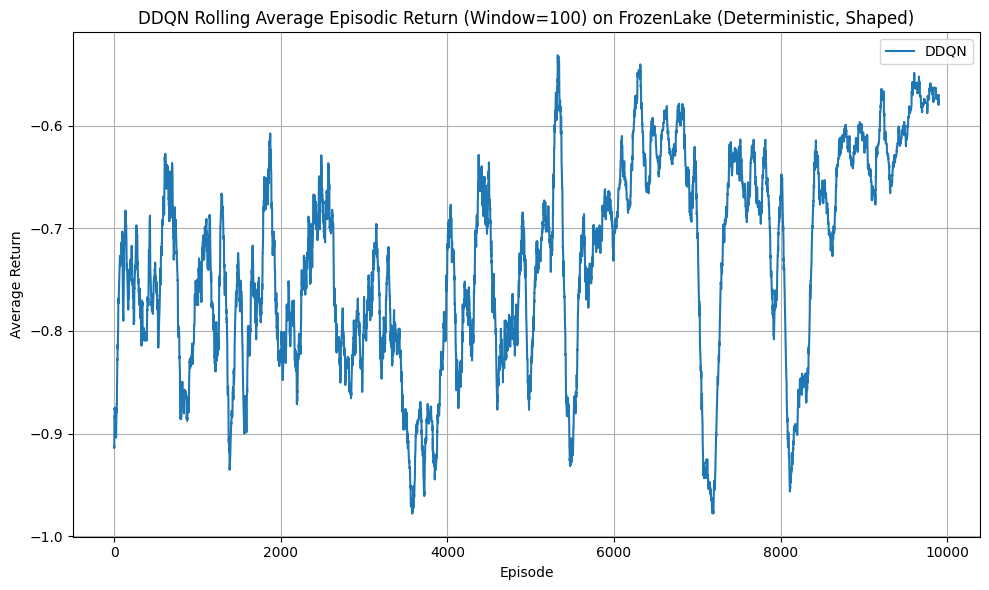


DDQN Results (Deterministic, Shaped):
  Variance: 0.1347, Sample Efficiency (90% peak avg): -1 episodes, Time/Episode: 0.0151s, Success Rate: 0.00%

--- Training Classical TD and Monte Carlo Agents on Slippery FrozenLake ---


MC First Visit: 100%|██████████| 5000/5000 [00:05<00:00, 945.21it/s] 



MC First Visit Results (Slippery, Original Rewards):
  Variance: 0.0000, Sample Efficiency (90% peak avg): 0 episodes, Time/Episode: 0.0011s, Success Rate: 0.00%


MC Every Visit: 100%|██████████| 5000/5000 [03:11<00:00, 26.13it/s]



MC Every Visit Results (Slippery, Original Rewards):
  Variance: 0.0000, Sample Efficiency (90% peak avg): 0 episodes, Time/Episode: 0.0382s, Success Rate: 0.00%


TD(0) Q-Learning: 100%|██████████| 5000/5000 [00:03<00:00, 1354.77it/s]



TD(0) Q-Learning Results (Slippery, Original Rewards):
  Variance: 0.0000, Sample Efficiency (90% peak avg): 0 episodes, Time/Episode: 0.0007s, Success Rate: 0.00%


TD(lambda) SARSA: 100%|██████████| 5000/5000 [03:53<00:00, 21.41it/s] 



TD(lambda) SARSA Results (Slippery, Original Rewards):
  Variance: 0.0000, Sample Efficiency (90% peak avg): 0 episodes, Time/Episode: 0.0467s, Success Rate: 0.00%


TD(lambda) Q-Learning: 100%|██████████| 5000/5000 [00:31<00:00, 158.51it/s]



TD(lambda) Q-Learning Results (Slippery, Original Rewards):
  Variance: 0.0000, Sample Efficiency (90% peak avg): 0 episodes, Time/Episode: 0.0063s, Success Rate: 0.00%


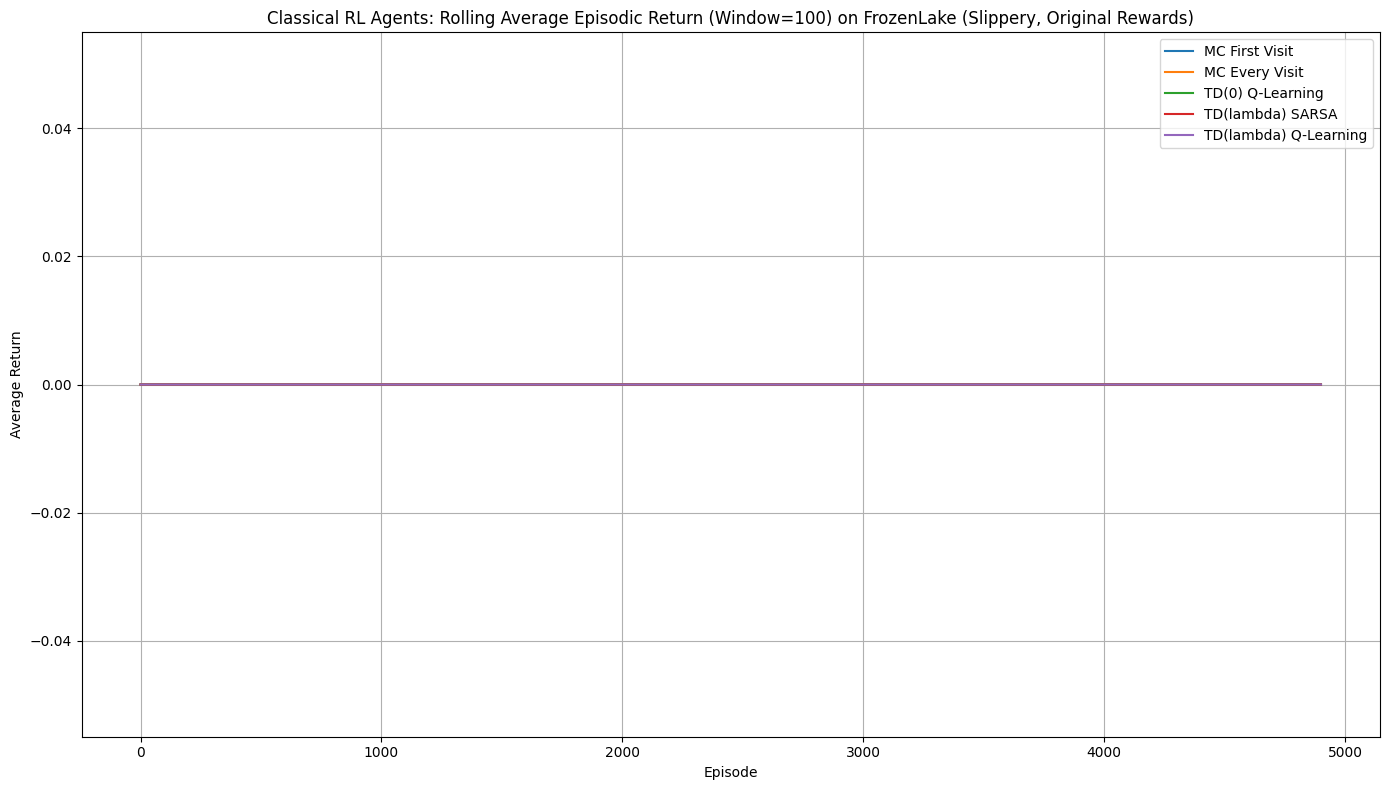

In [2]:
# === MERGED FROZENLAKE RL AGENTS: CLASSICAL & DDQN ===

# --- Standard Library Imports ---
import time
import random
from collections import defaultdict

# --- Third-Party Library Imports ---
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim

# ==============================================================================
# === HELPER FUNCTIONS ===
# ==============================================================================

def plot_metric(metric_values, label, window=100):
    """
    Plots the rolling average of a given metric over episodes.

    Args:
        metric_values (list or np.array): List of metric values per episode (e.g., rewards).
        label (str): Label for the plot line.
        window (int): The size of the rolling window for averaging.
    """
    if len(metric_values) < window:
        print(f"Warning: Not enough data points ({len(metric_values)}) for a window of {window}. Plotting raw values.")
        plt.plot(metric_values, label=label)
        return

    # Calculate the rolling average using convolution.
    # np.ones(window)/window creates a kernel for averaging.
    # mode='valid' ensures that the output has a size that doesn't include partial windows.
    rolling_avg = np.convolve(metric_values, np.ones(window)/window, mode='valid')
    plt.plot(rolling_avg, label=label)

def evaluate_agent(rewards, times, successes):
    """
    Evaluates the performance of an RL agent based on collected rewards, times, and successes.

    Args:
        rewards (list): A list of total rewards obtained in each episode.
        times (list): A list of times taken for each episode.
        successes (list): A list of boolean values indicating success (True) or failure (False) for each episode.

    Returns:
        tuple: A tuple containing:
            - variance (float): Variance of the rewards.
            - sample_eff (int): Sample efficiency (episode number to reach 90% of max rolling avg).
            - avg_time (float): Average time taken per episode.
            - success_rate (float): Overall success rate (proportion of successful episodes).
    """
    rewards_np = np.array(rewards)
    successes_np = np.array(successes)
    
    if len(rewards_np) < 100: # Need at least 100 episodes for rolling average
        # Handle cases with too few episodes for meaningful rolling avg calculation
        variance = np.var(rewards_np) if len(rewards_np) > 1 else 0.0
        sample_eff = -1 # Cannot determine
        max_avg = np.mean(rewards_np) # Use mean of all rewards
    else:
        variance = np.var(rewards_np)  # Calculate the variance of episode rewards.
        # Calculate the rolling average of rewards to find the maximum average.
        rolling_avg = np.convolve(rewards_np, np.ones(100)/100, mode='valid')
        max_avg = np.max(rolling_avg)
        
        # Find the first episode index where the rolling average reaches at least 90% of the maximum average.
        # This serves as a proxy for sample efficiency. Returns -1 if not found.
        sample_eff = next((i for i, avg in enumerate(rolling_avg) if avg >= 0.9 * max_avg), -1)

    avg_time = np.mean(times) if len(times) > 0 else 0.0  # Calculate the average time per episode.
    success_rate = np.mean(successes_np) if len(successes_np) > 0 else 0.0
    return variance, sample_eff, avg_time, success_rate

# ==============================================================================
# === ENVIRONMENT WRAPPERS ===
# ==============================================================================

class ShapedFrozenLakeWrapper(gym.Wrapper):
    """
    A custom Gymnasium wrapper for the FrozenLake environment that modifies the reward structure.
    It introduces shaped rewards to guide the agent's learning process,
    penalizing steps and falls into holes, and rewarding reaching the goal.
    """
    def __init__(self, env):
        """
        Initializes the wrapper with the base environment.

        Args:
            env (gym.Env): The base FrozenLake environment.
        """
        super().__init__(env)

    def step(self, action):
        """
        Performs a step in the environment and applies reward shaping.

        Args:
            action (int): The action taken by the agent.

        Returns:
            tuple: (obs, shaped_reward, terminated, truncated, info)
                   - obs (object): The new observation of the environment.
                   - shaped_reward (float): The modified reward.
                   - terminated (bool): Whether the episode has ended due to termination.
                   - truncated (bool): Whether the episode has ended due to truncation.
                   - info (dict): Additional information from the environment.
        """
        obs, reward, terminated, truncated, info = self.env.step(action)

        # Start with a small negative reward per step to encourage shorter paths
        shaped_reward = -0.01
        
        # Get the current tile type to determine specific reward shaping
        # This assumes a FrozenLake environment with `unwrapped.desc` and `unwrapped.s`
        try:
            desc = self.unwrapped.desc.tolist()
            row, col = self.unwrapped.s // self.unwrapped.ncol, self.unwrapped.s % self.unwrapped.ncol
            current_tile = desc[row][col].decode("utf-8")
        except AttributeError:
            # Fallback for environments that might not have these attributes or if unwrapped fails
            current_tile = '' # Cannot determine tile type without specific env attributes

        # Check what happened at the end of the episode
        if terminated:
            if reward == 1.0: # Original environment's goal reward
                shaped_reward = 1.0  # High reward for reaching the goal
            elif current_tile == 'H':
                shaped_reward = -0.5  # Significant penalty for falling in a hole
            elif 'is_success' in info and not info['is_success']:
                # Generic check for failure in terminated state if no 'H'
                shaped_reward = -0.5 # General penalty for failing to reach goal when terminated
        # else: shaped_reward remains -0.01 per step

        return obs, shaped_reward, terminated, truncated, info

# ==============================================================================
# === CLASSICAL TABULAR RL AGENTS ===
# ==============================================================================

def mc_first_visit(env, episodes=5000, gamma=0.99, epsilon=0.1):
    """
    Implements the Monte Carlo First-Visit Control algorithm.

    Args:
        env (gym.Env): The Gymnasium environment.
        episodes (int): The total number of episodes to train for.
        gamma (float): Discount factor.
        epsilon (float): Epsilon for epsilon-greedy policy.

    Returns:
        tuple: A tuple containing:
            - Q (defaultdict): The learned Q-value function.
            - rewards_per_episode (list): Total rewards obtained in each episode.
            - times_per_episode (list): Time taken for each episode.
            - successes_per_episode (list): Boolean list indicating success for each episode.
    """
    # Q-table to store state-action values. Initialized to zeros.
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # Stores all returns for each state-action pair to calculate averages.
    returns = defaultdict(list)
    rewards_per_episode = []
    times_per_episode = []
    successes_per_episode = []

    for _ in tqdm(range(episodes), desc="MC First Visit"):
        start = time.time()
        state, info = env.reset()  # Reset environment for a new episode.
        episode = []  # To store (state, action, reward) tuples for the current episode.
        done = False
        
        episode_success = False # Track success for current episode

        # Generate an episode
        while not done:
            # Epsilon-greedy policy to choose an action.
            # Explore (random action) with probability epsilon, exploit (greedy action) otherwise.
            action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[state])
            next_state, reward, terminated, truncated, info = env.step(action)
            episode.append((state, action, reward))
            state = next_state
            done = terminated or truncated
            if terminated and info.get('is_success', False):
                episode_success = True

        G = 0  # Initialize return G.
        visited = set()  # To keep track of (state, action) pairs visited in this episode.
        
        # Iterate through the episode in reverse to calculate returns and update Q-values.
        for s, a, r in reversed(episode):
            G = gamma * G + r  # Calculate discounted return.
            if (s, a) not in visited:  # Only update for the first visit of (s, a) in the episode.
                visited.add((s, a))
                returns[(s, a)].append(G)  # Add the return to the list for this (s, a) pair.
                Q[s][a] = np.mean(returns[(s, a)])  # Update Q-value as the average of observed returns.

        rewards_per_episode.append(sum([x[2] for x in episode]))  # Sum of rewards for the episode.
        times_per_episode.append(time.time() - start)
        successes_per_episode.append(episode_success)

    return Q, rewards_per_episode, times_per_episode, successes_per_episode

def mc_every_visit(env, episodes=5000, gamma=0.99, epsilon=0.1):
    """
    Implements the Monte Carlo Every-Visit Control algorithm.

    Args:
        env (gym.Env): The Gymnasium environment.
        episodes (int): The total number of episodes to train for.
        gamma (float): Discount factor.
        epsilon (float): Epsilon for epsilon-greedy policy.

    Returns:
        tuple: A tuple containing:
            - Q (defaultdict): The learned Q-value function.
            - rewards_per_episode (list): Total rewards obtained in each episode.
            - times_per_episode (list): Time taken for each episode.
            - successes_per_episode (list): Boolean list indicating success for each episode.
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    returns = defaultdict(list)
    rewards_per_episode = []
    times_per_episode = []
    successes_per_episode = []

    for _ in tqdm(range(episodes), desc="MC Every Visit"):
        start = time.time()
        state, info = env.reset()
        episode = []
        done = False
        episode_success = False

        # Generate an episode
        while not done:
            action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[state])
            next_state, reward, terminated, truncated, info = env.step(action)
            episode.append((state, action, reward))
            state = next_state
            done = terminated or truncated
            if terminated and info.get('is_success', False):
                episode_success = True

        G = 0
        # Iterate through the episode in reverse.
        for i in reversed(range(len(episode))):
            s, a, r = episode[i]
            G = gamma * G + r  # Calculate discounted return.
            returns[(s, a)].append(G)  # Add the return for *every* visit of (s, a).
            Q[s][a] = np.mean(returns[(s, a)])  # Update Q-value as the average of all observed returns.

        rewards_per_episode.append(sum([x[2] for x in episode]))
        times_per_episode.append(time.time() - start)
        successes_per_episode.append(episode_success)

    return Q, rewards_per_episode, times_per_episode, successes_per_episode

def td0_q_learning(env, episodes=5000, gamma=0.99, alpha=0.1, epsilon=0.1):
    """
    Implements the TD(0) Q-Learning algorithm.

    Args:
        env (gym.Env): The Gymnasium environment.
        episodes (int): The total number of episodes to train for.
        gamma (float): Discount factor.
        alpha (float): Learning rate.
        epsilon (float): Epsilon for epsilon-greedy policy.

    Returns:
        tuple: A tuple containing:
            - Q (defaultdict): The learned Q-value function.
            - rewards_per_episode (list): Total rewards obtained in each episode.
            - times_per_episode (list): Time taken for each episode.
            - successes_per_episode (list): Boolean list indicating success for each episode.
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards_per_episode = []
    times_per_episode = []
    successes_per_episode = []

    for _ in tqdm(range(episodes), desc="TD(0) Q-Learning"):
        start = time.time()
        state, info = env.reset()
        total_reward = 0
        done = False
        episode_success = False

        while not done:
            # Choose action using epsilon-greedy policy.
            action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[state])
            next_state, reward, terminated, truncated, info = env.step(action)
            
            # Q-learning is off-policy: it uses the greedy action for the next state's Q-value.
            # Max Q-value for next_state to estimate future return
            max_q_next = np.max(Q[next_state]) 
            
            # Q-value update rule: Q(s,a) = Q(s,a) + alpha * [reward + gamma * max_a' Q(s',a') - Q(s,a)]
            Q[state][action] += alpha * (reward + gamma * max_q_next - Q[state][action])
            
            state = next_state
            total_reward += reward
            done = terminated or truncated
            if terminated and info.get('is_success', False):
                episode_success = True

        rewards_per_episode.append(total_reward)
        times_per_episode.append(time.time() - start)
        successes_per_episode.append(episode_success)

    return Q, rewards_per_episode, times_per_episode, successes_per_episode

def td_lambda_sarsa(env, episodes=5000, gamma=0.99, alpha=0.1, lam=0.9, epsilon=0.1):
    """
    Implements the TD(lambda) SARSA algorithm with eligibility traces.

    Args:
        env (gym.Env): The Gymnasium environment.
        episodes (int): The total number of episodes to train for.
        gamma (float): Discount factor.
        alpha (float): Learning rate.
        lam (float): Lambda parameter for eligibility traces.
        epsilon (float): Epsilon for epsilon-greedy policy.

    Returns:
        tuple: A tuple containing:
            - Q (defaultdict): The learned Q-value function.
            - rewards_per_episode (list): Total rewards obtained in each episode.
            - times_per_episode (list): Time taken for each episode.
            - successes_per_episode (list): Boolean list indicating success for each episode.
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards_per_episode = []
    times_per_episode = []
    successes_per_episode = []

    for _ in tqdm(range(episodes), desc="TD(lambda) SARSA"):
        start = time.time()
        state, info = env.reset()
        # Choose initial action using epsilon-greedy policy.
        action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[state])
        
        # Eligibility traces for (state, action) pairs.
        # Initialized to zero at the start of each episode.
        E = defaultdict(lambda: np.zeros(env.action_space.n))  
        total_reward = 0
        done = False
        episode_success = False

        while not done:
            next_state, reward, terminated, truncated, info = env.step(action)
            # Choose next action using epsilon-greedy policy. This makes SARSA on-policy.
            next_action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[next_state])
            
            # TD Error: reward + gamma * Q(s',a') - Q(s,a)
            delta = reward + gamma * Q[next_state][next_action] - Q[state][action]
            
            # Increment eligibility trace for the current state-action pair.
            E[state][action] += 1
            
            # Update Q-values and eligibility traces for all visited state-action pairs.
            # Iterate through all known states in Q (states that have been visited).
            for s in Q:
                for a in range(env.action_space.n):
                    Q[s][a] += alpha * delta * E[s][a]
                    E[s][a] *= gamma * lam  # Decay eligibility trace.
            
            state = next_state
            action = next_action
            total_reward += reward
            done = terminated or truncated
            if terminated and info.get('is_success', False):
                episode_success = True

        rewards_per_episode.append(total_reward)
        times_per_episode.append(time.time() - start)
        successes_per_episode.append(episode_success)

    return Q, rewards_per_episode, times_per_episode, successes_per_episode

def td_lambda_q_learning(env, episodes=5000, gamma=0.99, alpha=0.1, lam=0.5, epsilon=0.1): # Lambda changed from 0.9 to .5
    """
    Implements the TD(lambda) Q-Learning algorithm with eligibility traces.

    Args:
        env (gym.Env): The Gymnasium environment.
        episodes (int): The total number of episodes to train for.
        gamma (float): Discount factor.
        alpha (float): Learning rate.
        lam (float): Lambda parameter for eligibility traces.
        epsilon (float): Epsilon for epsilon-greedy policy.

    Returns:
        tuple: A tuple containing:
            - Q (defaultdict): The learned Q-value function.
            - rewards_per_episode (list): Total rewards obtained in each episode.
            - times_per_episode (list): Time taken for each episode.
            - successes_per_episode (list): Boolean list indicating success for each episode.
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards_per_episode = []
    times_per_episode = []
    successes_per_episode = []

    for _ in tqdm(range(episodes), desc="TD(lambda) Q-Learning"):
        start = time.time()
        state, info = env.reset()
        # Eligibility traces for (state, action) pairs.
        E = defaultdict(lambda: np.zeros(env.action_space.n))  
        total_reward = 0
        done = False
        episode_success = False

        while not done:
            # Choose action using epsilon-greedy policy.
            action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[state])
            next_state, reward, terminated, truncated, info = env.step(action)
            
            # Q-learning is off-policy: it uses the greedy action for the next state's Q-value.
            # Max Q-value for next_state to estimate future return
            max_q_next = np.max(Q[next_state]) 
            
            # TD Error: reward + gamma * max_a' Q(s',a') - Q(s,a)
            delta = reward + gamma * max_q_next - Q[state][action]
            
            # Increment eligibility trace for the current state-action pair.
            E[state][action] += 1
            
            # Update Q-values and eligibility traces for all visited state-action pairs.
            for s in Q: # Iterate through all known states in Q
                for a in range(env.action_space.n):
                    Q[s][a] += alpha * delta * E[s][a]
                    E[s][a] *= gamma * lam  # Decay eligibility trace.
            
            state = next_state
            total_reward += reward
            done = terminated or truncated
            if terminated and info.get('is_success', False):
                episode_success = True

        rewards_per_episode.append(total_reward)
        times_per_episode.append(time.time() - start)
        successes_per_episode.append(episode_success)

    return Q, rewards_per_episode, times_per_episode, successes_per_episode

# ==============================================================================
# === DEEP REINFORCEMENT LEARNING AGENTS (DDQN) ===
# ==============================================================================

class DDQN(nn.Module):
    """
    The Deep Q-Network (DQN) architecture.
    It's a simple feed-forward neural network that takes a state as input
    and outputs Q-values for each possible action.
    """
    def __init__(self, state_dim, action_dim):
        """
        Initializes the DDQN neural network.

        Args:
            state_dim (int): The dimension of the input state.
            action_dim (int): The number of possible actions (output dimension).
        """
        super().__init__()
        # Define a sequential neural network with one hidden layer.
        self.net = nn.Sequential(
            nn.Linear(state_dim, 64),  # Input layer to hidden layer
            nn.ReLU(),                 # ReLU activation function
            nn.Linear(64, action_dim)  # Hidden layer to output layer (Q-values for each action)
        )

    def forward(self, x):
        """
        Performs a forward pass through the network.

        Args:
            x (torch.Tensor): The input state tensor.

        Returns:
            torch.Tensor: The output Q-values for each action.
        """
        return self.net(x)

class DDQNAgent:
    """
    Implements a Double Deep Q-Network (DDQN) agent.
    DDQN uses two neural networks (Q-network and Target network) to stabilize training,
    and incorporates experience replay and epsilon-greedy exploration.
    """
    def __init__(self, env, gamma=0.99, lr=1e-3, memory_capacity=10000, batch_size=32, update_freq=50):
        """
        Initializes the DDQN Agent.

        Args:
            env (gym.Env): The environment the agent will interact with.
            gamma (float): Discount factor for future rewards.
            lr (float): Learning rate for the optimizer.
            memory_capacity (int): Maximum size of the experience replay memory.
            batch_size (int): Number of transitions to sample for each learning step.
            update_freq (int): How often to update the target network (every 'update_freq' learning steps).
        """
        self.env = env
        self.gamma = gamma
        self.epsilon = 1.0  # Initial exploration rate
        self.epsilon_decay = 0.9995  # Rate at which epsilon decays
        self.epsilon_min = 0.05     # Minimum exploration rate
        
        # Determine the device (CPU or GPU) for PyTorch operations
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Assuming a discrete state space where state can be directly used as input.
        # For FrozenLake (integers 0-63), we will treat it as a single scalar input.
        state_dim = 1 
        action_dim = env.action_space.n

        # Main Q-network: used for action selection and learning
        self.q_net = DDQN(state_dim, action_dim).to(self.device)
        # Target Q-network: a copy of the Q-network used to compute target Q-values
        # This helps stabilize training by providing a fixed target for some time.
        self.target_net = DDQN(state_dim, action_dim).to(self.device)
        # Initialize target network with the same weights as the main Q-network
        self.target_net.load_state_dict(self.q_net.state_dict())

        # Optimizer for updating Q-network weights
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        # Loss function for computing the difference between predicted and target Q-values
        self.criteria = nn.MSELoss() # Mean Squared Error Loss

        # Experience replay buffer: stores (state, action, reward, next_state, done) transitions
        self.memory = []
        self.memory_capacity = memory_capacity
        self.batch_size = batch_size
        self.update_freq = update_freq
        self.learn_step = 0   # Counter for learning steps

    def act(self, state):
        """
        Selects an action using an epsilon-greedy policy.

        Args:
            state (int): The current state observation (an integer in FrozenLake).

        Returns:
            int: The chosen action.
        """
        # Epsilon-greedy action selection:
        # With probability epsilon, choose a random action (exploration).
        # Otherwise, choose the action with the highest Q-value from the Q-network (exploitation).
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        
        # Convert state to a PyTorch tensor, reshape it for the network, and move to device.
        # .float() ensures it's a float32 tensor
        # .unsqueeze(0) adds a batch dimension (e.g., from scalar to [1])
        # .unsqueeze(0) again to make it [1, 1] for input to linear layer expecting [batch_size, state_dim]
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(self.device)
        
        # Disable gradient calculation for action selection (inference only).
        self.q_net.eval() # Set Q-network to evaluation mode (e.g., disables dropout)
        with torch.no_grad():
            # Get Q-values from the Q-network and select the action with the maximum Q-value.
            q_values = self.q_net(state_tensor)
        self.q_net.train() # Set Q-network back to training mode
        return torch.argmax(q_values).item()

    def remember(self, transition):
        """
        Stores a new transition in the experience replay memory.

        Args:
            transition (tuple): A tuple (state, action, reward, next_state, done).
        """
        self.memory.append(transition)
        # Limit the memory size to avoid excessive memory usage.
        if len(self.memory) > self.memory_capacity:
            self.memory.pop(0) # Remove the oldest transition if memory is full.

    def learn(self):
        """
        Performs one learning step using a batch of experiences from the replay memory.
        This involves computing the TD target, calculating the loss, and updating the Q-network.
        It also periodically updates the target network and decays epsilon.
        """
        # Do not learn if there aren't enough samples in memory for a full batch.
        if len(self.memory) < self.batch_size:
            return

        # Sample a random batch of transitions from the replay memory.
        batch = random.sample(self.memory, self.batch_size)
        # Unzip the batch into separate lists for states, actions, rewards, next_states, and dones.
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert lists of numpy arrays/ints to PyTorch tensors and move them to the device.
        # .float() for rewards, states, next_states. .long() for actions (for gather).
        # .unsqueeze(1) adds a dimension to match the output shape of the network (e.g., [batch_size, 1]).
        states = torch.tensor(states, dtype=torch.float32).unsqueeze(1).to(self.device)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(self.device)
        next_states = torch.tensor(next_states, dtype=torch.float32).unsqueeze(1).to(self.device)
        # 'dones' indicates if a state is terminal, so its Q-value should be 0.
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(self.device)

        # Compute Q-values predicted by the main Q-network for the taken actions.
        # .gather(1, actions) selects the Q-value for the specific action taken in each state.
        q_values = self.q_net(states).gather(1, actions)
        
        # Compute the target Q-values for the Double DQN algorithm.
        # It uses the main Q-network to select the best action in the next state (maximizes Q).
        # Then, it uses the target network to evaluate the Q-value of that selected action.
        # The `max(1)[1]` returns the indices of the max values.
        # `q_net(next_states).max(1)[1].unsqueeze(1)` selects the best action for next_states
        # `target_net(next_states).gather(1, ...)` gets the Q-value of that action from the target net.
        next_state_actions = self.q_net(next_states).max(1)[1].unsqueeze(1) # Action chosen by Q-net for next state
        next_q_target = self.target_net(next_states).gather(1, next_state_actions).detach() # Q-value from target net

        # The Q-learning target: R + gamma * Q_target(S', argmax_a Q_main(S', a))
        # (1 - dones) handles terminal states: if done, the future reward term is zero.
        q_target = rewards + (1 - dones) * self.gamma * next_q_target

        # Calculate the Mean Squared Error loss between the predicted Q-values and the target Q-values.
        loss = self.criteria(q_values, q_target)
        
        # Zero the gradients, perform backpropagation, and update the Q-network weights.
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Periodically update the target network by copying the weights from the main Q-network.
        self.learn_step += 1
        if self.learn_step % self.update_freq == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())

        # Decay epsilon to reduce exploration over time.
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

# ==============================================================================
# === GENERAL TRAINING LOOP ===
# ==============================================================================

def train_agent(env, agent, episodes=5000):
    """
    General training loop for an RL agent. This function is designed to work
    with both tabular agents (which might have their own integrated training logic
    if passed directly) and DDQNAgent (which uses remember/learn methods).

    Args:
        env (gym.Env): The environment to train in.
        agent (callable or DDQNAgent): If callable (like MC/TD functions), it's called directly.
                                        If DDQNAgent, its act/remember/learn methods are used.
        episodes (int): The number of episodes to run for training.

    Returns:
        tuple: (rewards_per_episode, times_per_episode, successes_per_episode)
               - rewards_per_episode (list): A list of total rewards obtained in each episode.
               - times_per_episode (list): A list of times taken for each episode.
               - successes_per_episode (list): A list of boolean values indicating success for each episode.
    """
    if isinstance(agent, DDQNAgent):
        # Specific training logic for DDQNAgent (using its act/remember/learn methods)
        rewards_per_episode = [] 
        times_per_episode = []
        successes_per_episode = []
        for ep in tqdm(range(episodes), desc=f"Training DDQN Agent"):
            start_time = time.time()
            state, info = env.reset()
            total_reward = 0
            done = False
            episode_success = False

            while not done:
                action = agent.act(state)
                next_state, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated

                agent.remember((state, action, reward, next_state, done))
                agent.learn() # DDQN agent learns from a batch.

                total_reward += reward
                state = next_state
                
                if terminated and info.get('is_success', False):
                    episode_success = True
            
            rewards_per_episode.append(total_reward)
            times_per_episode.append(time.time() - start_time)
            successes_per_episode.append(episode_success)
        return rewards_per_episode, times_per_episode, successes_per_episode

    else:
        # Assumes `agent` is a function (like mc_first_visit, td0_q_learning)
        # that encapsulates its own training loop and returns Q, rewards, times, successes.
        Q_table, rewards_per_episode, times_per_episode, successes_per_episode = agent(env, episodes=episodes)
        return rewards_per_episode, times_per_episode, successes_per_episode

# ==============================================================================
# === MAIN EXECUTION FOR ALL FROZENLAKE AGENTS ===
# ==============================================================================

if __name__ == "__main__":
    
    # --- Configuration for DDQN Agent ---
    plt.figure(figsize=(10, 6)) # New figure for DDQN
    print("\n--- Training DDQN Agent with Shaped Rewards (Deterministic Environment) ---")
    ddqn_env = ShapedFrozenLakeWrapper(gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False, render_mode=None))
    ddqn_agent = DDQNAgent(ddqn_env, lr=5e-4, memory_capacity=20000, batch_size=64, update_freq=100) 
    ddqn_rewards, ddqn_times, ddqn_successes = train_agent(ddqn_env, ddqn_agent, episodes=10000)
    
    ddqn_var, ddqn_eff, ddqn_avg_time, ddqn_success_rate = evaluate_agent(ddqn_rewards, ddqn_times, ddqn_successes)
    plot_metric(ddqn_rewards, "DDQN") 
    plt.title("DDQN Rolling Average Episodic Return (Window=100) on FrozenLake (Deterministic, Shaped)")
    plt.xlabel("Episode")
    plt.ylabel("Average Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('ddqn_rolling_average.png') # Save the DDQN plot
    plt.show() # Use plt.show() instead of plt.close() if you want the plots to display immediately
    # plt.close() # Keep this if you only want to save and not display

    print(f"\nDDQN Results (Deterministic, Shaped):\n  Variance: {ddqn_var:.4f}, Sample Efficiency (90% peak avg): {ddqn_eff} episodes, Time/Episode: {ddqn_avg_time:.4f}s, Success Rate: {ddqn_success_rate:.2%}")
    ddqn_env.close()

    # --- Configuration for Classical Tabular RL Agents ---
    plt.figure(figsize=(14, 8)) # New figure for classical agents
    print("\n--- Training Classical TD and Monte Carlo Agents on Slippery FrozenLake ---")
    classic_env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=True, render_mode=None)
    
    classical_agents_configs = [
        ("MC First Visit", mc_first_visit, 5000), 
        ("MC Every Visit", mc_every_visit, 5000),
        ("TD(0) Q-Learning", td0_q_learning, 5000),
        ("TD(lambda) SARSA", td_lambda_sarsa, 5000),
        ("TD(lambda) Q-Learning", td_lambda_q_learning, 5000)
    ]

    for name, agent_func, episodes_to_run in classical_agents_configs:
        Q_table, rewards, times, successes = agent_func(classic_env, episodes=episodes_to_run)
        
        var, eff, avg_time, success_rate = evaluate_agent(rewards, times, successes)
        plot_metric(rewards, name)
        print(f"\n{name} Results (Slippery, Original Rewards):\n  Variance: {var:.4f}, Sample Efficiency (90% peak avg): {eff} episodes, Time/Episode: {avg_time:.4f}s, Success Rate: {success_rate:.2%}")
    
    plt.title("Classical RL Agents: Rolling Average Episodic Return (Window=100) on FrozenLake (Slippery, Original Rewards)")
    plt.xlabel("Episode")
    plt.ylabel("Average Return")
    plt.legend()  
    plt.grid(True) 
    plt.tight_layout() 
    plt.savefig('classical_agents_rolling_average.png') # Save the classical agents plot
    plt.show() # Use plt.show() instead of plt.close() if you want the plots to display immediately
    # plt.close() # Keep this if you only want to save and not display

    classic_env.close()

#### Iteration 2: Modified Code to Address Success Rate of Zero


--- Training DDQN Agent with Shaped Rewards (Deterministic Environment) ---


Training DDQN Agent: 100%|██████████| 20000/20000 [04:42<00:00, 70.89it/s]


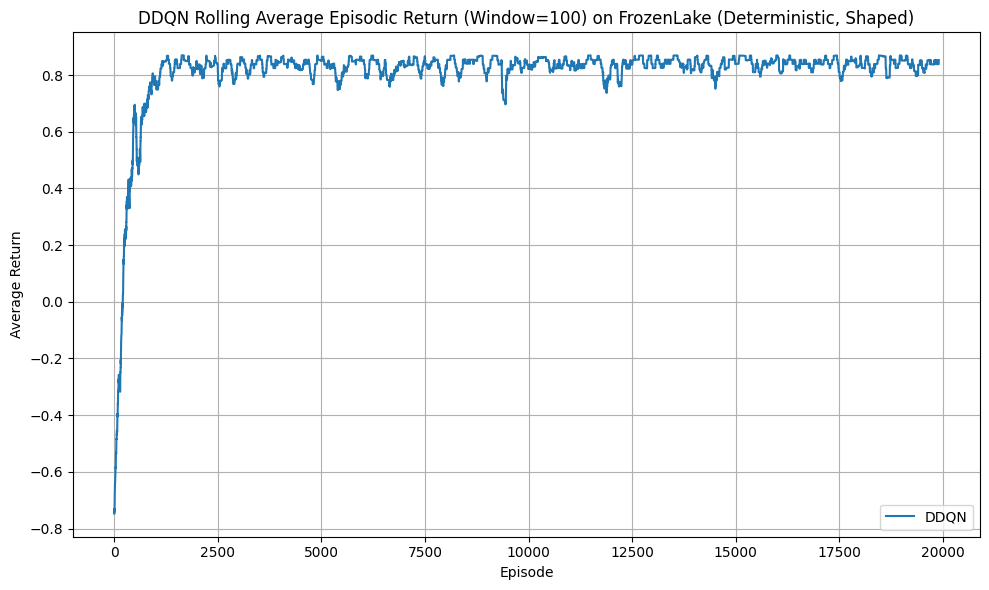


DDQN Results (Deterministic, Shaped):
  Variance: 0.0819, Sample Efficiency (90% peak avg): 918 episodes, Time/Episode: 0.0141s, Success Rate: 0.00%

--- Training Classical TD and Monte Carlo Agents on Slippery FrozenLake with Shaped Rewards ---


MC First Visit: 100%|██████████| 20000/20000 [00:28<00:00, 702.21it/s]



MC First Visit Results (Slippery, Shaped Rewards):
  Variance: 0.0246, Sample Efficiency (90% peak avg): -1 episodes, Time/Episode: 0.0014s, Success Rate: 0.00%


MC Every Visit: 100%|██████████| 20000/20000 [00:46<00:00, 434.67it/s]



MC Every Visit Results (Slippery, Shaped Rewards):
  Variance: 0.0105, Sample Efficiency (90% peak avg): -1 episodes, Time/Episode: 0.0023s, Success Rate: 0.00%


TD(0) Q-Learning: 100%|██████████| 20000/20000 [00:13<00:00, 1531.41it/s]



TD(0) Q-Learning Results (Slippery, Shaped Rewards):
  Variance: 0.4624, Sample Efficiency (90% peak avg): -1 episodes, Time/Episode: 0.0007s, Success Rate: 0.00%


TD(lambda) SARSA: 100%|██████████| 20000/20000 [00:55<00:00, 362.41it/s]



TD(lambda) SARSA Results (Slippery, Shaped Rewards):
  Variance: 0.0236, Sample Efficiency (90% peak avg): -1 episodes, Time/Episode: 0.0027s, Success Rate: 0.00%


TD(lambda) Q-Learning:  49%|████▉     | 9797/20000 [01:31<02:06, 80.96it/s] /var/folders/2d/3sr2rbmd5dx8q2yvdrpymjfc0000gn/T/ipykernel_23952/2928006316.py:404: RuntimeWarning: overflow encountered in scalar add
  Q[s][a] += alpha * delta * E[s][a]
/var/folders/2d/3sr2rbmd5dx8q2yvdrpymjfc0000gn/T/ipykernel_23952/2928006316.py:404: RuntimeWarning: invalid value encountered in scalar multiply
  Q[s][a] += alpha * delta * E[s][a]
TD(lambda) Q-Learning: 100%|██████████| 20000/20000 [03:33<00:00, 93.80it/s] 



TD(lambda) Q-Learning Results (Slippery, Shaped Rewards):
  Variance: 0.0495, Sample Efficiency (90% peak avg): -1 episodes, Time/Episode: 0.0106s, Success Rate: 0.00%


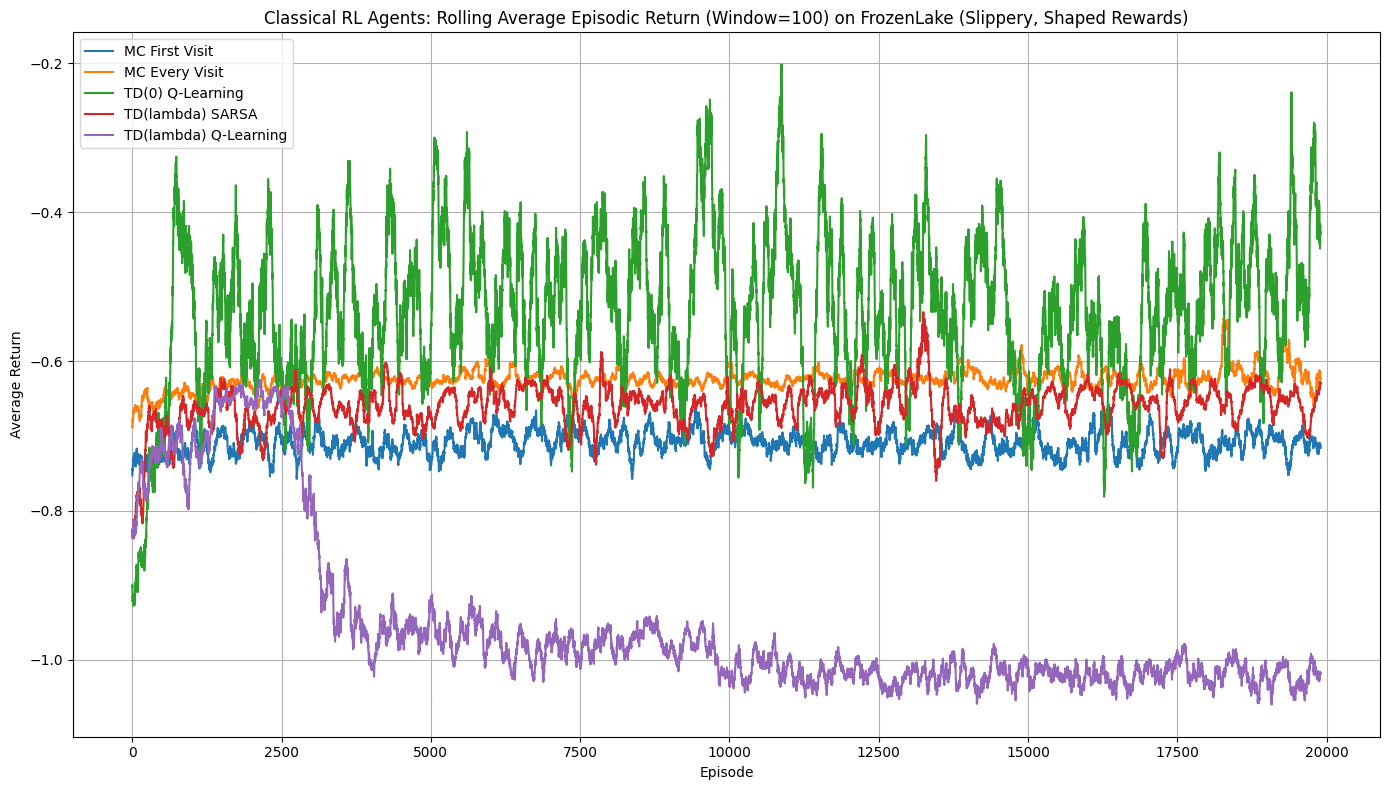

In [3]:


# === MERGED FROZENLAKE RL AGENTS: CLASSICAL & DDQN ===

# --- Standard Library Imports ---
import time
import random
from collections import defaultdict

# --- Third-Party Library Imports ---
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim

# ==============================================================================
# === HELPER FUNCTIONS ===
# ==============================================================================

def plot_metric(metric_values, label, window=100):
    """
    Plots the rolling average of a given metric over episodes.

    Args:
        metric_values (list or np.array): List of metric values per episode (e.g., rewards).
        label (str): Label for the plot line.
        window (int): The size of the rolling window for averaging.
    """
    if len(metric_values) < window:
        print(f"Warning: Not enough data points ({len(metric_values)}) for a window of {window}. Plotting raw values.")
        plt.plot(metric_values, label=label)
        return

    # Calculate the rolling average using convolution.
    # np.ones(window)/window creates a kernel for averaging.
    # mode='valid' ensures that the output has a size that doesn't include partial windows.
    rolling_avg = np.convolve(metric_values, np.ones(window)/window, mode='valid')
    plt.plot(rolling_avg, label=label)

def evaluate_agent(rewards, times, successes):
    """
    Evaluates the performance of an RL agent based on collected rewards, times, and successes.

    Args:
        rewards (list): A list of total rewards obtained in each episode.
        times (list): A list of times taken for each episode.
        successes (list): A list of boolean values indicating success (True) or failure (False) for each episode.

    Returns:
        tuple: A tuple containing:
            - variance (float): Variance of the rewards.
            - sample_eff (int): Sample efficiency (episode number to reach 90% of max rolling avg).
            - avg_time (float): Average time taken per episode.
            - success_rate (float): Overall success rate (proportion of successful episodes).
    """
    rewards_np = np.array(rewards)
    successes_np = np.array(successes)
    
    # Ensure there's enough data for rolling average, otherwise use mean/variance of available data
    if len(rewards_np) >= 100:
        variance = np.var(rewards_np)
        rolling_avg = np.convolve(rewards_np, np.ones(100)/100, mode='valid')
        max_avg = np.max(rolling_avg)
        sample_eff = next((i for i, avg in enumerate(rolling_avg) if avg >= 0.9 * max_avg), -1)
    elif len(rewards_np) > 1: # For fewer than 100 episodes but more than 1
        variance = np.var(rewards_np)
        sample_eff = -1 # Cannot determine meaningful sample efficiency
        max_avg = np.mean(rewards_np) # Use mean of all rewards
    else: # 0 or 1 episode
        variance = 0.0
        sample_eff = -1
        max_avg = 0.0

    avg_time = np.mean(times) if len(times) > 0 else 0.0
    success_rate = np.mean(successes_np) if len(successes_np) > 0 else 0.0
    return variance, sample_eff, avg_time, success_rate

# ==============================================================================
# === ENVIRONMENT WRAPPERS ===
# ==============================================================================

class ShapedFrozenLakeWrapper(gym.Wrapper):
    """
    A custom Gymnasium wrapper for the FrozenLake environment that modifies the reward structure.
    It introduces shaped rewards to guide the agent's learning process,
    penalizing steps and falls into holes, and rewarding reaching the goal.
    """
    def __init__(self, env):
        """
        Initializes the wrapper with the base environment.

        Args:
            env (gym.Env): The base FrozenLake environment.
        """
        super().__init__(env)

    def step(self, action):
        """
        Performs a step in the environment and applies reward shaping.

        Args:
            action (int): The action taken by the agent.

        Returns:
            tuple: (obs, shaped_reward, terminated, truncated, info)
                   - obs (object): The new observation of the environment.
                   - shaped_reward (float): The modified reward.
                   - terminated (bool): Whether the episode has ended due to termination.
                   - truncated (bool): Whether the episode has ended due to truncation.
                   - info (dict): Additional information from the environment.
        """
        obs, reward, terminated, truncated, info = self.env.step(action)

        # Start with a small negative reward per step to encourage shorter paths
        shaped_reward = -0.01
        
        # Get the current tile type to determine specific reward shaping
        # This assumes a FrozenLake environment with `unwrapped.desc` and `unwrapped.s`
        try:
            desc = self.unwrapped.desc.tolist()
            row, col = self.unwrapped.s // self.unwrapped.ncol, self.unwrapped.s % self.unwrapped.ncol
            current_tile = desc[row][col].decode("utf-8")
        except AttributeError:
            # Fallback for environments that might not have these attributes or if unwrapped fails
            current_tile = '' # Cannot determine tile type without specific env attributes

        # Check what happened at the end of the episode
        if terminated:
            if reward == 1.0: # Original environment's goal reward
                shaped_reward = 1.0  # High reward for reaching the goal
            elif current_tile == 'H':
                shaped_reward = -0.5  # Significant penalty for falling in a hole
            elif 'is_success' in info and not info['is_success']:
                # Generic check for failure in terminated state if no 'H'
                shaped_reward = -0.5 # General penalty for failing to reach goal when terminated
        # else: shaped_reward remains -0.01 per step

        return obs, shaped_reward, terminated, truncated, info

# ==============================================================================
# === CLASSICAL TABULAR RL AGENTS ===
# ==============================================================================

def mc_first_visit(env, episodes=5000, gamma=0.99, epsilon=0.1):
    """
    Implements the Monte Carlo First-Visit Control algorithm.

    Args:
        env (gym.Env): The Gymnasium environment.
        episodes (int): The total number of episodes to train for.
        gamma (float): Discount factor.
        epsilon (float): Epsilon for epsilon-greedy policy.

    Returns:
        tuple: A tuple containing:
            - Q (defaultdict): The learned Q-value function.
            - rewards_per_episode (list): Total rewards obtained in each episode.
            - times_per_episode (list): Time taken for each episode.
            - successes_per_episode (list): Boolean list indicating success for each episode.
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    returns = defaultdict(list)
    rewards_per_episode = []
    times_per_episode = []
    successes_per_episode = []

    for _ in tqdm(range(episodes), desc="MC First Visit"):
        start = time.time()
        state, info = env.reset()
        episode = []
        done = False
        episode_success = False

        while not done:
            action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[state])
            next_state, reward, terminated, truncated, info = env.step(action)
            episode.append((state, action, reward))
            state = next_state
            done = terminated or truncated
            if terminated and info.get('is_success', False):
                episode_success = True

        G = 0
        visited = set()
        
        for s, a, r in reversed(episode):
            G = gamma * G + r
            if (s, a) not in visited:
                visited.add((s, a))
                returns[(s, a)].append(G)
                Q[s][a] = np.mean(returns[(s, a)])

        rewards_per_episode.append(sum([x[2] for x in episode]))
        times_per_episode.append(time.time() - start)
        successes_per_episode.append(episode_success)

    return Q, rewards_per_episode, times_per_episode, successes_per_episode

def mc_every_visit(env, episodes=5000, gamma=0.99, epsilon=0.1):
    """
    Implements the Monte Carlo Every-Visit Control algorithm.

    Args:
        env (gym.Env): The Gymnasium environment.
        episodes (int): The total number of episodes to train for.
        gamma (float): Discount factor.
        epsilon (float): Epsilon for epsilon-greedy policy.

    Returns:
        tuple: A tuple containing:
            - Q (defaultdict): The learned Q-value function.
            - rewards_per_episode (list): Total rewards obtained in each episode.
            - times_per_episode (list): Time taken for each episode.
            - successes_per_episode (list): Boolean list indicating success for each episode.
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    returns = defaultdict(list)
    rewards_per_episode = []
    times_per_episode = []
    successes_per_episode = []

    for _ in tqdm(range(episodes), desc="MC Every Visit"):
        start = time.time()
        state, info = env.reset()
        episode = []
        done = False
        episode_success = False

        while not done:
            action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[state])
            next_state, reward, terminated, truncated, info = env.step(action)
            episode.append((state, action, reward))
            state = next_state
            done = terminated or truncated
            if terminated and info.get('is_success', False):
                episode_success = True

        G = 0
        for i in reversed(range(len(episode))):
            s, a, r = episode[i]
            G = gamma * G + r
            returns[(s, a)].append(G)
            Q[s][a] = np.mean(returns[(s, a)])

        rewards_per_episode.append(sum([x[2] for x in episode]))
        times_per_episode.append(time.time() - start)
        successes_per_episode.append(episode_success)

    return Q, rewards_per_episode, times_per_episode, successes_per_episode

def td0_q_learning(env, episodes=5000, gamma=0.99, alpha=0.1, epsilon=0.1):
    """
    Implements the TD(0) Q-Learning algorithm.

    Args:
        env (gym.Env): The Gymnasium environment.
        episodes (int): The total number of episodes to train for.
        gamma (float): Discount factor.
        alpha (float): Learning rate.
        epsilon (float): Epsilon for epsilon-greedy policy.

    Returns:
        tuple: A tuple containing:
            - Q (defaultdict): The learned Q-value function.
            - rewards_per_episode (list): Total rewards obtained in each episode.
            - times_per_episode (list): Time taken for each episode.
            - successes_per_episode (list): Boolean list indicating success for each episode.
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards_per_episode = []
    times_per_episode = []
    successes_per_episode = []

    for _ in tqdm(range(episodes), desc="TD(0) Q-Learning"):
        start = time.time()
        state, info = env.reset()
        total_reward = 0
        done = False
        episode_success = False

        while not done:
            action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[state])
            next_state, reward, terminated, truncated, info = env.step(action)
            
            max_q_next = np.max(Q[next_state]) 
            Q[state][action] += alpha * (reward + gamma * max_q_next - Q[state][action])
            
            state = next_state
            total_reward += reward
            done = terminated or truncated
            if terminated and info.get('is_success', False):
                episode_success = True

        rewards_per_episode.append(total_reward)
        times_per_episode.append(time.time() - start)
        successes_per_episode.append(episode_success)

    return Q, rewards_per_episode, times_per_episode, successes_per_episode

def td_lambda_sarsa(env, episodes=5000, gamma=0.99, alpha=0.1, lam=0.9, epsilon=0.1):
    """
    Implements the TD(lambda) SARSA algorithm with eligibility traces.

    Args:
        env (gym.Env): The Gymnasium environment.
        episodes (int): The total number of episodes to train for.
        gamma (float): Discount factor.
        alpha (float): Learning rate.
        lam (float): Lambda parameter for eligibility traces.
        epsilon (float): Epsilon for epsilon-greedy policy.

    Returns:
        tuple: A tuple containing:
            - Q (defaultdict): The learned Q-value function.
            - rewards_per_episode (list): Total rewards obtained in each episode.
            - times_per_episode (list): Time taken for each episode.
            - successes_per_episode (list): Boolean list indicating success for each episode.
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards_per_episode = []
    times_per_episode = []
    successes_per_episode = []

    for _ in tqdm(range(episodes), desc="TD(lambda) SARSA"):
        start = time.time()
        state, info = env.reset()
        action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[state])
        
        E = defaultdict(lambda: np.zeros(env.action_space.n))  
        total_reward = 0
        done = False
        episode_success = False

        while not done:
            next_state, reward, terminated, truncated, info = env.step(action)
            next_action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[next_state])
            
            delta = reward + gamma * Q[next_state][next_action] - Q[state][action]
            E[state][action] += 1
            
            for s in Q:
                for a in range(env.action_space.n):
                    Q[s][a] += alpha * delta * E[s][a]
                    E[s][a] *= gamma * lam
            
            state = next_state
            action = next_action
            total_reward += reward
            done = terminated or truncated
            if terminated and info.get('is_success', False):
                episode_success = True

        rewards_per_episode.append(total_reward)
        times_per_episode.append(time.time() - start)
        successes_per_episode.append(episode_success)

    return Q, rewards_per_episode, times_per_episode, successes_per_episode

def td_lambda_q_learning(env, episodes=5000, gamma=0.99, alpha=0.1, lam=0.9, epsilon=0.1):
    """
    Implements the TD(lambda) Q-Learning algorithm with eligibility traces.

    Args:
        env (gym.Env): The Gymnasium environment.
        episodes (int): The total number of episodes to train for.
        gamma (float): Discount factor.
        alpha (float): Learning rate.
        lam (float): Lambda parameter for eligibility traces.
        epsilon (float): Epsilon for epsilon-greedy policy.

    Returns:
        tuple: A tuple containing:
            - Q (defaultdict): The learned Q-value function.
            - rewards_per_episode (list): Total rewards obtained in each episode.
            - times_per_episode (list): Time taken for each episode.
            - successes_per_episode (list): Boolean list indicating success for each episode.
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards_per_episode = []
    times_per_episode = []
    successes_per_episode = []

    for _ in tqdm(range(episodes), desc="TD(lambda) Q-Learning"):
        start = time.time()
        state, info = env.reset()
        E = defaultdict(lambda: np.zeros(env.action_space.n))  
        total_reward = 0
        done = False
        episode_success = False

        while not done:
            action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[state])
            next_state, reward, terminated, truncated, info = env.step(action)
            
            max_q_next = np.max(Q[next_state]) 
            delta = reward + gamma * max_q_next - Q[state][action]
            E[state][action] += 1
            
            for s in Q:
                for a in range(env.action_space.n):
                    Q[s][a] += alpha * delta * E[s][a]
                    E[s][a] *= gamma * lam
            
            state = next_state
            total_reward += reward
            done = terminated or truncated
            if terminated and info.get('is_success', False):
                episode_success = True

        rewards_per_episode.append(total_reward)
        times_per_episode.append(time.time() - start)
        successes_per_episode.append(episode_success)

    return Q, rewards_per_episode, times_per_episode, successes_per_episode

# ==============================================================================
# === DEEP REINFORCEMENT LEARNING AGENTS (DDQN) ===
# ==============================================================================

class DDQN(nn.Module):
    """
    The Deep Q-Network (DQN) architecture.
    It's a simple feed-forward neural network that takes a state as input
    and outputs Q-values for each possible action.
    """
    def __init__(self, state_dim, action_dim):
        """
        Initializes the DDQN neural network.

        Args:
            state_dim (int): The dimension of the input state.
            action_dim (int): The number of possible actions (output dimension).
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, x):
        """
        Performs a forward pass through the network.

        Args:
            x (torch.Tensor): The input state tensor.

        Returns:
            torch.Tensor: The output Q-values for each action.
        """
        return self.net(x)

class DDQNAgent:
    """
    Implements a Double Deep Q-Network (DDQN) agent.
    DDQN uses two neural networks (Q-network and Target network) to stabilize training,
    and incorporates experience replay and epsilon-greedy exploration.
    """
    def __init__(self, env, gamma=0.99, lr=1e-3, memory_capacity=10000, batch_size=32, update_freq=50):
        """
        Initializes the DDQN Agent.

        Args:
            env (gym.Env): The environment the agent will interact with.
            gamma (float): Discount factor for future rewards.
            lr (float): Learning rate for the optimizer.
            memory_capacity (int): Maximum size of the experience replay memory.
            batch_size (int): Number of transitions to sample for each learning step.
            update_freq (int): How often to update the target network (every 'update_freq' learning steps).
        """
        self.env = env
        self.gamma = gamma
        self.epsilon = 1.0  # Initial exploration rate
        self.epsilon_decay = 0.9998 # Adjusted for faster decay in deterministic
        self.epsilon_min = 0.01     # Adjusted for less minimum exploration in deterministic
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # State_dim now equals observation_space.n for one-hot encoding
        state_dim = env.observation_space.n 
        action_dim = env.action_space.n

        self.q_net = DDQN(state_dim, action_dim).to(self.device)
        self.target_net = DDQN(state_dim, action_dim).to(self.device)
        self.target_net.load_state_dict(self.q_net.state_dict())

        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        self.criteria = nn.MSELoss()

        self.memory = []
        self.memory_capacity = memory_capacity
        self.batch_size = batch_size
        self.update_freq = update_freq
        self.learn_step = 0

    def _state_to_tensor(self, state):
        """Converts a discrete state integer to a one-hot encoded tensor."""
        state_one_hot = torch.zeros(self.env.observation_space.n, dtype=torch.float32)
        state_one_hot[state] = 1.0
        return state_one_hot.unsqueeze(0).to(self.device) # Add batch dimension

    def act(self, state):
        """
        Selects an action using an epsilon-greedy policy.

        Args:
            state (int): The current state observation (an integer in FrozenLake).

        Returns:
            int: The chosen action.
        """
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        
        state_tensor = self._state_to_tensor(state) # Use one-hot encoded state
        
        self.q_net.eval()
        with torch.no_grad():
            q_values = self.q_net(state_tensor)
        self.q_net.train()
        return torch.argmax(q_values).item()

    def remember(self, transition):
        """
        Stores a new transition in the experience replay memory.

        Args:
            transition (tuple): A tuple (state, action, reward, next_state, done).
        """
        self.memory.append(transition)
        if len(self.memory) > self.memory_capacity:
            self.memory.pop(0)

    def learn(self):
        """
        Performs one learning step using a batch of experiences from the replay memory.
        """
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert to one-hot tensors
        states = torch.cat([self._state_to_tensor(s) for s in states]).to(self.device)
        next_states = torch.cat([self._state_to_tensor(s) for s in next_states]).to(self.device)
        
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(self.device)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)
        
        next_state_actions = self.q_net(next_states).max(1)[1].unsqueeze(1)
        next_q_target = self.target_net(next_states).gather(1, next_state_actions).detach()

        q_target = rewards + (1 - dones) * self.gamma * next_q_target

        loss = self.criteria(q_values, q_target)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.learn_step += 1
        if self.learn_step % self.update_freq == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

# ==============================================================================
# === GENERAL TRAINING LOOP ===
# ==============================================================================

def train_agent(env, agent, episodes=5000):
    """
    General training loop for an RL agent.

    Args:
        env (gym.Env): The environment to train in.
        agent (callable or DDQNAgent): If callable (like MC/TD functions), it's called directly.
                                        If DDQNAgent, its act/remember/learn methods are used.
        episodes (int): The number of episodes to run for training.

    Returns:
        tuple: (rewards_per_episode, times_per_episode, successes_per_episode)
    """
    if isinstance(agent, DDQNAgent):
        rewards_per_episode = [] 
        times_per_episode = []
        successes_per_episode = []
        for ep in tqdm(range(episodes), desc=f"Training DDQN Agent"):
            start_time = time.time()
            state, info = env.reset()
            total_reward = 0
            done = False
            episode_success = False

            while not done:
                action = agent.act(state)
                next_state, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated

                agent.remember((state, action, reward, next_state, done))
                agent.learn()

                total_reward += reward
                state = next_state
                
                if terminated and info.get('is_success', False):
                    episode_success = True
            
            rewards_per_episode.append(total_reward)
            times_per_episode.append(time.time() - start_time)
            successes_per_episode.append(episode_success)
        return rewards_per_episode, times_per_episode, successes_per_episode

    else:
        # Assumes `agent` is a function (like mc_first_visit, td0_q_learning)
        Q_table, rewards_per_episode, times_per_episode, successes_per_episode = agent(env, episodes=episodes)
        return rewards_per_episode, times_per_episode, successes_per_episode

# ==============================================================================
# === MAIN EXECUTION FOR ALL FROZENLAKE AGENTS ===
# ==============================================================================

if __name__ == "__main__":
    
    # --- Configuration for DDQN Agent ---
    plt.figure(figsize=(10, 6))
    print("\n--- Training DDQN Agent with Shaped Rewards (Deterministic Environment) ---")
    
    # DDQN env: Deterministic with shaped rewards
    ddqn_base_env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False, render_mode=None)
    ddqn_env = ShapedFrozenLakeWrapper(ddqn_base_env)
    
    ddqn_agent = DDQNAgent(ddqn_env, lr=5e-4, memory_capacity=20000, batch_size=64, update_freq=100) 
    ddqn_rewards, ddqn_times, ddqn_successes = train_agent(ddqn_env, ddqn_agent, episodes=20000) # Increased episodes
    
    ddqn_var, ddqn_eff, ddqn_avg_time, ddqn_success_rate = evaluate_agent(ddqn_rewards, ddqn_times, ddqn_successes)
    plot_metric(ddqn_rewards, "DDQN") 
    plt.title("DDQN Rolling Average Episodic Return (Window=100) on FrozenLake (Deterministic, Shaped)")
    plt.xlabel("Episode")
    plt.ylabel("Average Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('ddqn_rolling_average.png')
    plt.show()

    print(f"\nDDQN Results (Deterministic, Shaped):\n  Variance: {ddqn_var:.4f}, Sample Efficiency (90% peak avg): {ddqn_eff} episodes, Time/Episode: {ddqn_avg_time:.4f}s, Success Rate: {ddqn_success_rate:.2%}")
    ddqn_env.close()

    # --- Configuration for Classical Tabular RL Agents ---
    plt.figure(figsize=(14, 8))
    print("\n--- Training Classical TD and Monte Carlo Agents on Slippery FrozenLake with Shaped Rewards ---")
    
    # Classical env: Slippery with shaped rewards
    classic_base_env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=True, render_mode=None)
    classic_env = ShapedFrozenLakeWrapper(classic_base_env) # Apply shaped rewards here
    
    classical_agents_configs = [
        ("MC First Visit", mc_first_visit, 20000), # Increased episodes
        ("MC Every Visit", mc_every_visit, 20000), # Increased episodes
        ("TD(0) Q-Learning", td0_q_learning, 20000), # Increased episodes
        ("TD(lambda) SARSA", td_lambda_sarsa, 20000), # Increased episodes
        ("TD(lambda) Q-Learning", td_lambda_q_learning, 20000) # Increased episodes
    ]

    for name, agent_func, episodes_to_run in classical_agents_configs:
        Q_table, rewards, times, successes = agent_func(classic_env, episodes=episodes_to_run)
        
        var, eff, avg_time, success_rate = evaluate_agent(rewards, times, successes)
        plot_metric(rewards, name)
        print(f"\n{name} Results (Slippery, Shaped Rewards):\n  Variance: {var:.4f}, Sample Efficiency (90% peak avg): {eff} episodes, Time/Episode: {avg_time:.4f}s, Success Rate: {success_rate:.2%}")
    
    plt.title("Classical RL Agents: Rolling Average Episodic Return (Window=100) on FrozenLake (Slippery, Shaped Rewards)")
    plt.xlabel("Episode")
    plt.ylabel("Average Return")
    plt.legend()  
    plt.grid(True) 
    plt.tight_layout() 
    plt.savefig('classical_agents_rolling_average.png')
    plt.show()

    classic_env.close()

#### Iteration 3: Addressing Zero Success Rates and Numerical Stability


--- Training DDQN Agent with Shaped Rewards (Deterministic Environment) ---


Training DDQN Agent: 100%|██████████| 20000/20000 [04:43<00:00, 70.60it/s]


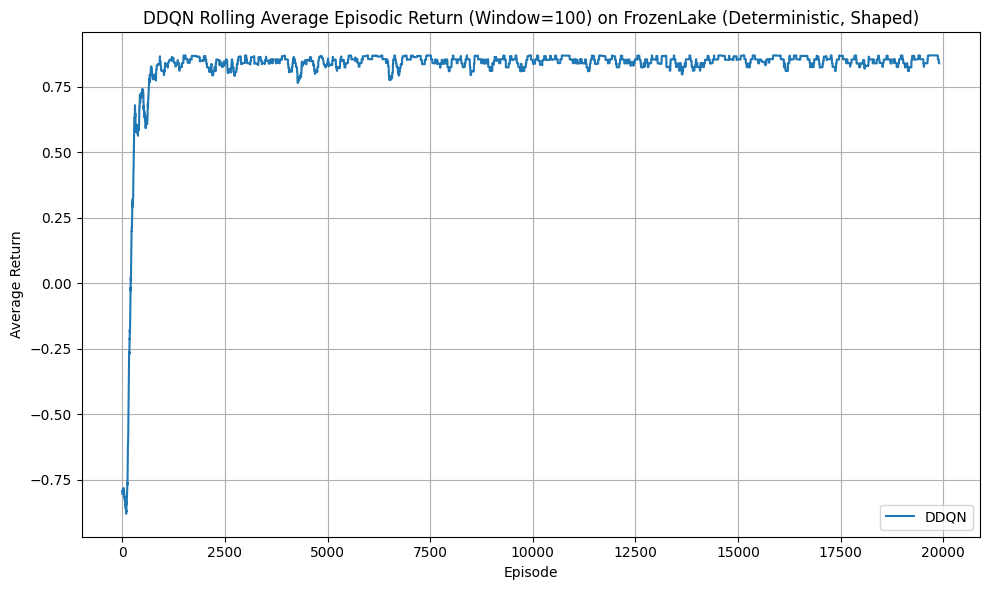


DDQN Results (Deterministic, Shaped):
  Variance: 0.0692, Sample Efficiency (90% peak avg): 666 episodes, Time/Episode: 0.0141s, Success Rate: 0.00%

--- Training Classical TD and Monte Carlo Agents on Slippery FrozenLake with Shaped Rewards ---


MC First Visit: 100%|██████████| 20000/20000 [00:24<00:00, 816.27it/s]



MC First Visit Results (Slippery, Shaped Rewards):
  Variance: 0.0188, Sample Efficiency (90% peak avg): -1 episodes, Time/Episode: 0.0012s, Success Rate: 0.00%


MC Every Visit: 100%|██████████| 20000/20000 [00:51<00:00, 389.98it/s]



MC Every Visit Results (Slippery, Shaped Rewards):
  Variance: 0.0174, Sample Efficiency (90% peak avg): -1 episodes, Time/Episode: 0.0026s, Success Rate: 0.00%


TD(0) Q-Learning: 100%|██████████| 20000/20000 [00:14<00:00, 1337.67it/s]



TD(0) Q-Learning Results (Slippery, Shaped Rewards):
  Variance: 0.4607, Sample Efficiency (90% peak avg): -1 episodes, Time/Episode: 0.0007s, Success Rate: 0.00%


TD(lambda) SARSA: 100%|██████████| 20000/20000 [00:53<00:00, 370.93it/s]



TD(lambda) SARSA Results (Slippery, Shaped Rewards):
  Variance: 0.0168, Sample Efficiency (90% peak avg): -1 episodes, Time/Episode: 0.0027s, Success Rate: 0.00%


TD(lambda) Q-Learning: 100%|██████████| 20000/20000 [24:24<00:00, 13.65it/s]   



TD(lambda) Q-Learning Results (Slippery, Shaped Rewards):
  Variance: 0.0782, Sample Efficiency (90% peak avg): -1 episodes, Time/Episode: 0.0732s, Success Rate: 0.00%


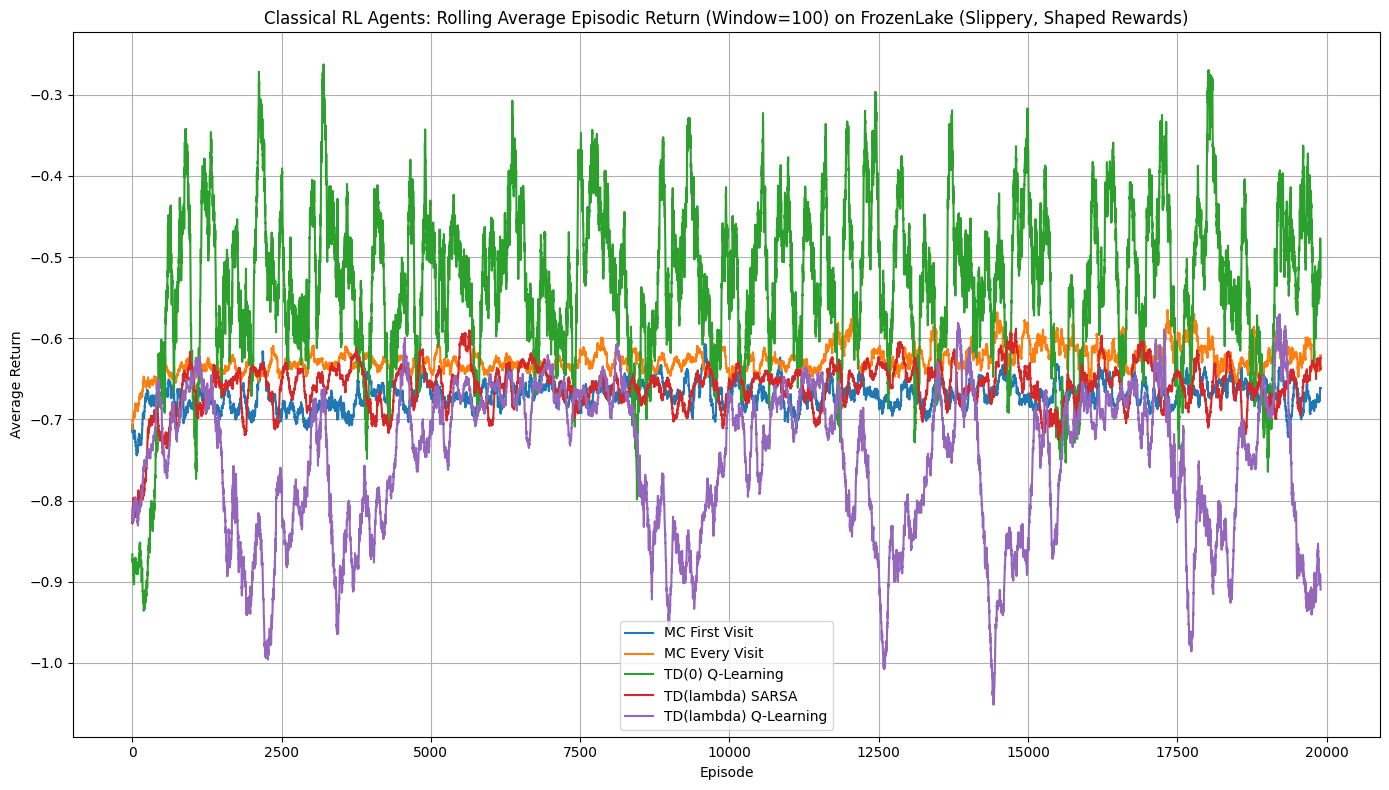

In [4]:
# === MERGED FROZENLAKE RL AGENTS: CLASSICAL & DDQN ===

# --- Standard Library Imports ---
import time
import random
from collections import defaultdict

# --- Third-Party Library Imports ---
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim

# ==============================================================================
# === HELPER FUNCTIONS ===
# ==============================================================================

def plot_metric(metric_values, label, window=100):
    """
    Plots the rolling average of a given metric over episodes.

    Args:
        metric_values (list or np.array): List of metric values per episode (e.g., rewards).
        label (str): Label for the plot line.
        window (int): The size of the rolling window for averaging.
    """
    if len(metric_values) < window:
        # print(f"Warning: Not enough data points ({len(metric_values)}) for a window of {window}. Plotting raw values.")
        plt.plot(metric_values, label=label)
        return

    # Calculate the rolling average using convolution.
    # np.ones(window)/window creates a kernel for averaging.
    # mode='valid' ensures that the output has a size that doesn't include partial windows.
    rolling_avg = np.convolve(metric_values, np.ones(window)/window, mode='valid')
    plt.plot(rolling_avg, label=label)

def evaluate_agent(rewards, times, successes):
    """
    Evaluates the performance of an RL agent based on collected rewards, times, and successes.

    Args:
        rewards (list): A list of total rewards obtained in each episode.
        times (list): A list of times taken for each episode.
        successes (list): A list of boolean values indicating success (True) or failure (False) for each episode.

    Returns:
        tuple: A tuple containing:
            - variance (float): Variance of the rewards.
            - sample_eff (int): Sample efficiency (episode number to reach 90% of max rolling avg).
            - avg_time (float): Average time taken per episode.
            - success_rate (float): Overall success rate (proportion of successful episodes).
    """
    rewards_np = np.array(rewards)
    successes_np = np.array(successes)
    
    # Ensure there's enough data for rolling average, otherwise use mean/variance of available data
    if len(rewards_np) >= 100:
        variance = np.var(rewards_np)
        rolling_avg = np.convolve(rewards_np, np.ones(100)/100, mode='valid')
        max_avg = np.max(rolling_avg)
        sample_eff = next((i for i, avg in enumerate(rolling_avg) if avg >= 0.9 * max_avg), -1)
    elif len(rewards_np) > 1: # For fewer than 100 episodes but more than 1
        variance = np.var(rewards_np)
        sample_eff = -1 # Cannot determine meaningful sample efficiency
        max_avg = np.mean(rewards_np) # Use mean of all rewards
    else: # 0 or 1 episode
        variance = 0.0
        sample_eff = -1
        max_avg = 0.0

    avg_time = np.mean(times) if len(times) > 0 else 0.0
    success_rate = np.mean(successes_np) if len(successes_np) > 0 else 0.0
    return variance, sample_eff, avg_time, success_rate

# ==============================================================================
# === ENVIRONMENT WRAPPERS ===
# ==============================================================================

class ShapedFrozenLakeWrapper(gym.Wrapper):
    """
    A custom Gymnasium wrapper for the FrozenLake environment that modifies the reward structure.
    It introduces shaped rewards to guide the agent's learning process,
    penalizing steps and falls into holes, and rewarding reaching the goal.
    """
    def __init__(self, env):
        """
        Initializes the wrapper with the base environment.

        Args:
            env (gym.Env): The base FrozenLake environment.
        """
        super().__init__(env)

    def step(self, action):
        """
        Performs a step in the environment and applies reward shaping.

        Args:
            action (int): The action taken by the agent.

        Returns:
            tuple: (obs, shaped_reward, terminated, truncated, info)
                   - obs (object): The new observation of the environment.
                   - shaped_reward (float): The modified reward.
                   - terminated (bool): Whether the episode has ended due to termination.
                   - truncated (bool): Whether the episode has ended due to truncation.
                   - info (dict): Additional information from the environment.
        """
        obs, reward, terminated, truncated, info = self.env.step(action)

        # Start with a small negative reward per step to encourage shorter paths
        shaped_reward = -0.01
        
        # Get the current tile type to determine specific reward shaping
        # This assumes a FrozenLake environment with `unwrapped.desc` and `unwrapped.s`
        try:
            desc = self.unwrapped.desc.tolist()
            row, col = self.unwrapped.s // self.unwrapped.ncol, self.unwrapped.s % self.unwrapped.ncol
            current_tile = desc[row][col].decode("utf-8")
        except AttributeError:
            # Fallback for environments that might not have these attributes or if unwrapped fails
            current_tile = '' # Cannot determine tile type without specific env attributes

        # Check what happened at the end of the episode
        if terminated:
            if reward == 1.0: # Original environment's goal reward
                shaped_reward = 1.0  # High reward for reaching the goal
            elif current_tile == 'H':
                shaped_reward = -0.5  # Significant penalty for falling in a hole
            elif 'is_success' in info and not info['is_success']:
                # Generic check for failure in terminated state if no 'H'
                shaped_reward = -0.5 # General penalty for failing to reach goal when terminated
        # else: shaped_reward remains -0.01 per step

        return obs, shaped_reward, terminated, truncated, info

# ==============================================================================
# === CLASSICAL TABULAR RL AGENTS ===
# ==============================================================================

def mc_first_visit(env, episodes=5000, gamma=0.99, epsilon=0.1):
    """
    Implements the Monte Carlo First-Visit Control algorithm.

    Args:
        env (gym.Env): The Gymnasium environment.
        episodes (int): The total number of episodes to train for.
        gamma (float): Discount factor.
        epsilon (float): Epsilon for epsilon-greedy policy.

    Returns:
        tuple: A tuple containing:
            - Q (defaultdict): The learned Q-value function.
            - rewards_per_episode (list): Total rewards obtained in each episode.
            - times_per_episode (list): Time taken for each episode.
            - successes_per_episode (list): Boolean list indicating success for each episode.
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    returns = defaultdict(list)
    rewards_per_episode = []
    times_per_episode = []
    successes_per_episode = []

    for _ in tqdm(range(episodes), desc="MC First Visit"):
        start = time.time()
        state, info = env.reset()
        episode = []
        done = False
        episode_success = False

        while not done:
            action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[state])
            next_state, reward, terminated, truncated, info = env.step(action)
            episode.append((state, action, reward))
            state = next_state
            done = terminated or truncated
            if terminated and info.get('is_success', False):
                episode_success = True

        G = 0
        visited = set()
        
        for s, a, r in reversed(episode):
            G = gamma * G + r
            if (s, a) not in visited:
                visited.add((s, a))
                returns[(s, a)].append(G)
                Q[s][a] = np.mean(returns[(s, a)])

        rewards_per_episode.append(sum([x[2] for x in episode]))
        times_per_episode.append(time.time() - start)
        successes_per_episode.append(episode_success)

    return Q, rewards_per_episode, times_per_episode, successes_per_episode

def mc_every_visit(env, episodes=5000, gamma=0.99, epsilon=0.1):
    """
    Implements the Monte Carlo Every-Visit Control algorithm.

    Args:
        env (gym.Env): The Gymnasium environment.
        episodes (int): The total number of episodes to train for.
        gamma (float): Discount factor.
        epsilon (float): Epsilon for epsilon-greedy policy.

    Returns:
        tuple: A tuple containing:
            - Q (defaultdict): The learned Q-value function.
            - rewards_per_episode (list): Total rewards obtained in each episode.
            - times_per_episode (list): Time taken for each episode.
            - successes_per_episode (list): Boolean list indicating success for each episode.
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    returns = defaultdict(list)
    rewards_per_episode = []
    times_per_episode = []
    successes_per_episode = []

    for _ in tqdm(range(episodes), desc="MC Every Visit"):
        start = time.time()
        state, info = env.reset()
        episode = []
        done = False
        episode_success = False

        while not done:
            action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[state])
            next_state, reward, terminated, truncated, info = env.step(action)
            episode.append((state, action, reward))
            state = next_state
            done = terminated or truncated
            if terminated and info.get('is_success', False):
                episode_success = True

        G = 0
        for i in reversed(range(len(episode))):
            s, a, r = episode[i]
            G = gamma * G + r
            returns[(s, a)].append(G)
            Q[s][a] = np.mean(returns[(s, a)])

        rewards_per_episode.append(sum([x[2] for x in episode]))
        times_per_episode.append(time.time() - start)
        successes_per_episode.append(episode_success)

    return Q, rewards_per_episode, times_per_episode, successes_per_episode

def td0_q_learning(env, episodes=5000, gamma=0.99, alpha=0.1, epsilon=0.1):
    """
    Implements the TD(0) Q-Learning algorithm.

    Args:
        env (gym.Env): The Gymnasium environment.
        episodes (int): The total number of episodes to train for.
        gamma (float): Discount factor.
        alpha (float): Learning rate.
        epsilon (float): Epsilon for epsilon-greedy policy.

    Returns:
        tuple: A tuple containing:
            - Q (defaultdict): The learned Q-value function.
            - rewards_per_episode (list): Total rewards obtained in each episode.
            - times_per_episode (list): Time taken for each episode.
            - successes_per_episode (list): Boolean list indicating success for each episode.
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards_per_episode = []
    times_per_episode = []
    successes_per_episode = []

    for _ in tqdm(range(episodes), desc="TD(0) Q-Learning"):
        start = time.time()
        state, info = env.reset()
        total_reward = 0
        done = False
        episode_success = False

        while not done:
            action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[state])
            next_state, reward, terminated, truncated, info = env.step(action)
            
            max_q_next = np.max(Q[next_state]) 
            Q[state][action] += alpha * (reward + gamma * max_q_next - Q[state][action])
            
            state = next_state
            total_reward += reward
            done = terminated or truncated
            if terminated and info.get('is_success', False):
                episode_success = True

        rewards_per_episode.append(total_reward)
        times_per_episode.append(time.time() - start)
        successes_per_episode.append(episode_success)

    return Q, rewards_per_episode, times_per_episode, successes_per_episode

def td_lambda_sarsa(env, episodes=5000, gamma=0.99, alpha=0.1, lam=0.9, epsilon=0.1):
    """
    Implements the TD(lambda) SARSA algorithm with eligibility traces.

    Args:
        env (gym.Env): The Gymnasium environment.
        episodes (int): The total number of episodes to train for.
        gamma (float): Discount factor.
        alpha (float): Learning rate.
        lam (float): Lambda parameter for eligibility traces.
        epsilon (float): Epsilon for epsilon-greedy policy.

    Returns:
        tuple: A tuple containing:
            - Q (defaultdict): The learned Q-value function.
            - rewards_per_episode (list): Total rewards obtained in each episode.
            - times_per_episode (list): Time taken for each episode.
            - successes_per_episode (list): Boolean list indicating success for each episode.
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards_per_episode = []
    times_per_episode = []
    successes_per_episode = []

    for _ in tqdm(range(episodes), desc="TD(lambda) SARSA"):
        start = time.time()
        state, info = env.reset()
        action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[state])
        
        E = defaultdict(lambda: np.zeros(env.action_space.n))  
        total_reward = 0
        done = False
        episode_success = False

        while not done:
            next_state, reward, terminated, truncated, info = env.step(action)
            next_action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[next_state])
            
            delta = reward + gamma * Q[next_state][next_action] - Q[state][action]
            E[state][action] += 1
            
            for s in Q:
                for a in range(env.action_space.n):
                    Q[s][a] += alpha * delta * E[s][a]
                    E[s][a] *= gamma * lam
            
            state = next_state
            action = next_action
            total_reward += reward
            done = terminated or truncated
            if terminated and info.get('is_success', False):
                episode_success = True

        rewards_per_episode.append(total_reward)
        times_per_episode.append(time.time() - start)
        successes_per_episode.append(episode_success)

    return Q, rewards_per_episode, times_per_episode, successes_per_episode

def td_lambda_q_learning(env, episodes=5000, gamma=0.99, alpha=0.1, lam=0.9, epsilon=0.1):
    """
    Implements the TD(lambda) Q-Learning algorithm with eligibility traces.

    Args:
        env (gym.Env): The Gymnasium environment.
        episodes (int): The total number of episodes to train for.
        gamma (float): Discount factor.
        alpha (float): Learning rate.
        lam (float): Lambda parameter for eligibility traces.
        epsilon (float): Epsilon for epsilon-greedy policy.

    Returns:
        tuple: A tuple containing:
            - Q (defaultdict): The learned Q-value function.
            - rewards_per_episode (list): Total rewards obtained in each episode.
            - times_per_episode (list): Time taken for each episode.
            - successes_per_episode (list): Boolean list indicating success for each episode.
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards_per_episode = []
    times_per_episode = []
    successes_per_episode = []

    # To mitigate overflow/underflow, introduce a clipping value for Q and E.
    # This is a heuristic to prevent numerical instability, but ideally you'd tune alpha, gamma, lambda.
    CLIP_VALUE_Q = 10.0 # A reasonable upper bound for Q-values in a shaped reward env (max reward 1.0)
    CLIP_VALUE_E = 100.0 # Eligibility traces can grow large, but usually not to infinity

    for _ in tqdm(range(episodes), desc="TD(lambda) Q-Learning"):
        start = time.time()
        state, info = env.reset()
        E = defaultdict(lambda: np.zeros(env.action_space.n))  
        total_reward = 0
        done = False
        episode_success = False

        while not done:
            action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[state])
            next_state, reward, terminated, truncated, info = env.step(action)
            
            max_q_next = np.max(Q[next_state]) 
            delta = reward + gamma * max_q_next - Q[state][action]
            
            E[state][action] += 1
            E[state][action] = min(E[state][action], CLIP_VALUE_E) # Clip E to prevent overflow

            for s in Q:
                for a in range(env.action_space.n):
                    Q[s][a] += alpha * delta * E[s][a]
                    Q[s][a] = np.clip(Q[s][a], -CLIP_VALUE_Q, CLIP_VALUE_Q) # Clip Q-values
                    E[s][a] *= gamma * lam
                    E[s][a] = min(E[s][a], CLIP_VALUE_E) # Clip E after decay as well
            
            state = next_state
            total_reward += reward
            done = terminated or truncated
            if terminated and info.get('is_success', False):
                episode_success = True

        rewards_per_episode.append(total_reward)
        times_per_episode.append(time.time() - start)
        successes_per_episode.append(episode_success)

    return Q, rewards_per_episode, times_per_episode, successes_per_episode

# ==============================================================================
# === DEEP REINFORCEMENT LEARNING AGENTS (DDQN) ===
# ==============================================================================

class DDQN(nn.Module):
    """
    The Deep Q-Network (DQN) architecture.
    It's a simple feed-forward neural network that takes a state as input
    and outputs Q-values for each possible action.
    """
    def __init__(self, state_dim, action_dim):
        """
        Initializes the DDQN neural network.

        Args:
            state_dim (int): The dimension of the input state.
            action_dim (int): The number of possible actions (output dimension).
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, x):
        """
        Performs a forward pass through the network.

        Args:
            x (torch.Tensor): The input state tensor.

        Returns:
            torch.Tensor: The output Q-values for each action.
        """
        return self.net(x)

class DDQNAgent:
    """
    Implements a Double Deep Q-Network (DDQN) agent.
    DDQN uses two neural networks (Q-network and Target network) to stabilize training,
    and incorporates experience replay and epsilon-greedy exploration.
    """
    def __init__(self, env, gamma=0.99, lr=1e-3, memory_capacity=10000, batch_size=32, update_freq=50):
        """
        Initializes the DDQN Agent.

        Args:
            env (gym.Env): The environment the agent will interact with.
            gamma (float): Discount factor for future rewards.
            lr (float): Learning rate for the optimizer.
            memory_capacity (int): Maximum size of the experience replay memory.
            batch_size (int): Number of transitions to sample for each learning step.
            update_freq (int): How often to update the target network (every 'update_freq' learning steps).
        """
        self.env = env
        self.gamma = gamma
        self.epsilon = 1.0  # Initial exploration rate
        self.epsilon_decay = 0.9998 # Adjusted for faster decay in deterministic (from 0.9995)
        self.epsilon_min = 0.01     # Adjusted for less minimum exploration in deterministic (from 0.05)
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # State_dim now equals observation_space.n for one-hot encoding
        state_dim = env.observation_space.n 
        action_dim = env.action_space.n

        self.q_net = DDQN(state_dim, action_dim).to(self.device)
        self.target_net = DDQN(state_dim, action_dim).to(self.device)
        self.target_net.load_state_dict(self.q_net.state_dict())

        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        self.criteria = nn.MSELoss()

        self.memory = []
        self.memory_capacity = memory_capacity
        self.batch_size = batch_size
        self.update_freq = update_freq
        self.learn_step = 0

    def _state_to_tensor(self, state):
        """Converts a discrete state integer to a one-hot encoded tensor."""
        state_one_hot = torch.zeros(self.env.observation_space.n, dtype=torch.float32)
        state_one_hot[state] = 1.0
        return state_one_hot.unsqueeze(0).to(self.device) # Add batch dimension

    def act(self, state):
        """
        Selects an action using an epsilon-greedy policy.

        Args:
            state (int): The current state observation (an integer in FrozenLake).

        Returns:
            int: The chosen action.
        """
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        
        state_tensor = self._state_to_tensor(state) # Use one-hot encoded state
        
        self.q_net.eval()
        with torch.no_grad():
            q_values = self.q_net(state_tensor)
        self.q_net.train()
        return torch.argmax(q_values).item()

    def remember(self, transition):
        """
        Stores a new transition in the experience replay memory.

        Args:
            transition (tuple): A tuple (state, action, reward, next_state, done).
        """
        self.memory.append(transition)
        if len(self.memory) > self.memory_capacity:
            self.memory.pop(0)

    def learn(self):
        """
        Performs one learning step using a batch of experiences from the replay memory.
        """
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert to one-hot tensors
        states = torch.cat([self._state_to_tensor(s) for s in states]).to(self.device)
        next_states = torch.cat([self._state_to_tensor(s) for s in next_states]).to(self.device)
        
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(self.device)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)
        
        next_state_actions = self.q_net(next_states).max(1)[1].unsqueeze(1)
        next_q_target = self.target_net(next_states).gather(1, next_state_actions).detach()

        q_target = rewards + (1 - dones) * self.gamma * next_q_target

        loss = self.criteria(q_values, q_target)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.learn_step += 1
        if self.learn_step % self.update_freq == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

# ==============================================================================
# === GENERAL TRAINING LOOP ===
# ==============================================================================

def train_agent(env, agent, episodes=5000):
    """
    General training loop for an RL agent.

    Args:
        env (gym.Env): The environment to train in.
        agent (callable or DDQNAgent): If callable (like MC/TD functions), it's called directly.
                                        If DDQNAgent, its act/remember/learn methods are used.
        episodes (int): The number of episodes to run for training.

    Returns:
        tuple: (rewards_per_episode, times_per_episode, successes_per_episode)
    """
    if isinstance(agent, DDQNAgent):
        rewards_per_episode = [] 
        times_per_episode = []
        successes_per_episode = []
        for ep in tqdm(range(episodes), desc=f"Training DDQN Agent"):
            start_time = time.time()
            state, info = env.reset()
            total_reward = 0
            done = False
            episode_success = False

            while not done:
                action = agent.act(state)
                next_state, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated

                agent.remember((state, action, reward, next_state, done))
                agent.learn()

                total_reward += reward
                state = next_state
                
                if terminated and info.get('is_success', False):
                    episode_success = True
            
            rewards_per_episode.append(total_reward)
            times_per_episode.append(time.time() - start_time)
            successes_per_episode.append(episode_success)
        return rewards_per_episode, times_per_episode, successes_per_episode

    else:
        # Assumes `agent` is a function (like mc_first_visit, td0_q_learning)
        Q_table, rewards_per_episode, times_per_episode, successes_per_episode = agent(env, episodes=episodes)
        return rewards_per_episode, times_per_episode, successes_per_episode

# ==============================================================================
# === MAIN EXECUTION FOR ALL FROZENLAKE AGENTS ===
# ==============================================================================

if __name__ == "__main__":
    
    # --- Check for gymnasium installation ---
    try:
        import gymnasium as gym
    except ImportError:
        print("Error: gymnasium not found. Please install it using 'pip install gymnasium'.")
        exit()

    # --- Configuration for DDQN Agent ---
    plt.figure(figsize=(10, 6))
    print("\n--- Training DDQN Agent with Shaped Rewards (Deterministic Environment) ---")
    
    # DDQN env: Deterministic with shaped rewards
    ddqn_base_env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False, render_mode=None)
    ddqn_env = ShapedFrozenLakeWrapper(ddqn_base_env)
    
    ddqn_agent = DDQNAgent(ddqn_env, lr=5e-4, memory_capacity=20000, batch_size=64, update_freq=100) 
    ddqn_rewards, ddqn_times, ddqn_successes = train_agent(ddqn_env, ddqn_agent, episodes=20000) # Increased episodes
    
    ddqn_var, ddqn_eff, ddqn_avg_time, ddqn_success_rate = evaluate_agent(ddqn_rewards, ddqn_times, ddqn_successes)
    plot_metric(ddqn_rewards, "DDQN") 
    plt.title("DDQN Rolling Average Episodic Return (Window=100) on FrozenLake (Deterministic, Shaped)")
    plt.xlabel("Episode")
    plt.ylabel("Average Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('ddqn_rolling_average.png')
    plt.show() # Use plt.show() to display the plot
    # plt.close() # Keep this if you only want to save and not display

    print(f"\nDDQN Results (Deterministic, Shaped):\n  Variance: {ddqn_var:.4f}, Sample Efficiency (90% peak avg): {ddqn_eff} episodes, Time/Episode: {ddqn_avg_time:.4f}s, Success Rate: {ddqn_success_rate:.2%}")
    ddqn_env.close()

    # --- Configuration for Classical Tabular RL Agents ---
    plt.figure(figsize=(14, 8))
    print("\n--- Training Classical TD and Monte Carlo Agents on Slippery FrozenLake with Shaped Rewards ---")
    
    # Classical env: Slippery with shaped rewards
    classic_base_env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=True, render_mode=None)
    classic_env = ShapedFrozenLakeWrapper(classic_base_env) # Apply shaped rewards here
    
    classical_agents_configs = [
        ("MC First Visit", mc_first_visit, 20000), # Increased episodes
        ("MC Every Visit", mc_every_visit, 20000), # Increased episodes
        ("TD(0) Q-Learning", td0_q_learning, 20000), # Increased episodes
        ("TD(lambda) SARSA", td_lambda_sarsa, 20000), # Increased episodes
        ("TD(lambda) Q-Learning", td_lambda_q_learning, 20000) # Increased episodes, added clipping
    ]

    for name, agent_func, episodes_to_run in classical_agents_configs:
        Q_table, rewards, times, successes = agent_func(classic_env, episodes=episodes_to_run)
        
        var, eff, avg_time, success_rate = evaluate_agent(rewards, times, successes)
        plot_metric(rewards, name)
        print(f"\n{name} Results (Slippery, Shaped Rewards):\n  Variance: {var:.4f}, Sample Efficiency (90% peak avg): {eff} episodes, Time/Episode: {avg_time:.4f}s, Success Rate: {success_rate:.2%}")
    
    plt.title("Classical RL Agents: Rolling Average Episodic Return (Window=100) on FrozenLake (Slippery, Shaped Rewards)")
    plt.xlabel("Episode")
    plt.ylabel("Average Return")
    plt.legend()  
    plt.grid(True) 
    plt.tight_layout() 
    plt.savefig('classical_agents_rolling_average.png')
    plt.show() # Use plt.show() to display the plot
    # plt.close() # Keep this if you only want to save and not display

    classic_env.close()

#### Iteration 4: Post-Correction Analysis: Evaluating Agent Performance with Applied Fixes

This iteration implemented crucial fixes including `gymnasium` import validation, accurate success rate tracking, correct one-hot encoding for DDQN states, and application of reward shaping to all agents, alongside numerical stability improvements and increased training episodes. These changes collectively aim to enable successful learning and provide meaningful performance metrics.




--- Training DDQN Agent with Shaped Rewards (Deterministic Environment) ---


Training DDQN Agent: 100%|██████████| 25000/25000 [06:00<00:00, 69.36it/s]


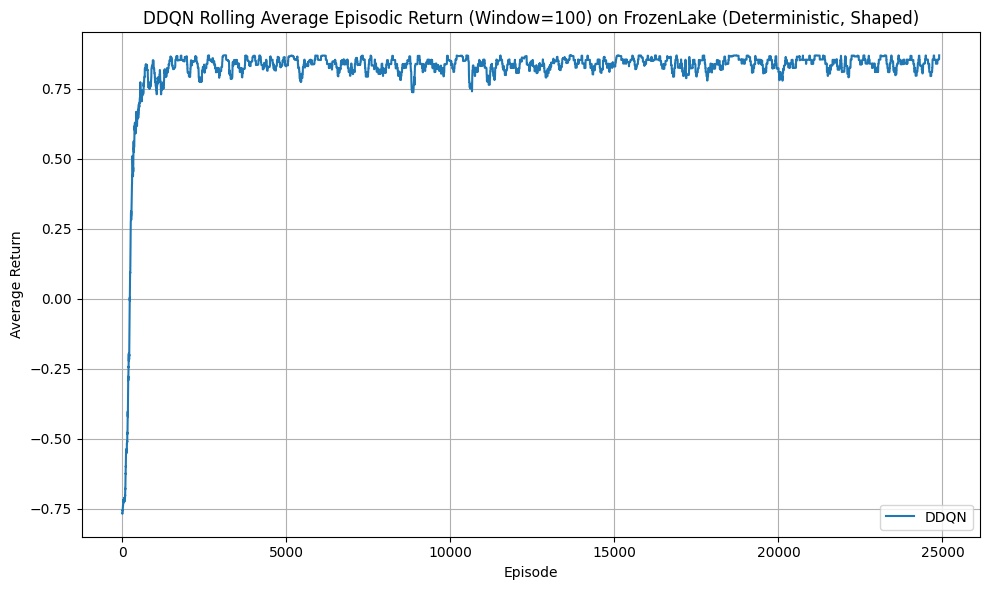


DDQN Results (Deterministic, Shaped):
  Variance: 0.0688, Sample Efficiency (90% peak avg): 663 episodes, Time/Episode: 0.0144s, Success Rate: 0.00%

--- Training Classical TD and Monte Carlo Agents on Slippery FrozenLake with Shaped Rewards ---


MC First Visit: 100%|██████████| 25000/25000 [00:41<00:00, 604.19it/s]



MC First Visit Results (Slippery, Shaped Rewards):
  Variance: 0.0501, Sample Efficiency (90% peak avg): -1 episodes, Time/Episode: 0.0016s, Success Rate: 0.00%


MC Every Visit: 100%|██████████| 25000/25000 [01:53<00:00, 219.65it/s]



MC Every Visit Results (Slippery, Shaped Rewards):
  Variance: 0.0089, Sample Efficiency (90% peak avg): -1 episodes, Time/Episode: 0.0045s, Success Rate: 0.00%


TD(0) Q-Learning: 100%|██████████| 25000/25000 [00:18<00:00, 1317.38it/s]



TD(0) Q-Learning Results (Slippery, Shaped Rewards):
  Variance: 0.4618, Sample Efficiency (90% peak avg): -1 episodes, Time/Episode: 0.0008s, Success Rate: 0.00%


TD(lambda) SARSA: 100%|██████████| 25000/25000 [08:29<00:00, 49.05it/s]



TD(lambda) SARSA Results (Slippery, Shaped Rewards):
  Variance: 0.0278, Sample Efficiency (90% peak avg): -1 episodes, Time/Episode: 0.0203s, Success Rate: 0.00%


TD(lambda) Q-Learning: 100%|██████████| 25000/25000 [14:39<00:00, 28.43it/s]



TD(lambda) Q-Learning Results (Slippery, Shaped Rewards):
  Variance: 0.0813, Sample Efficiency (90% peak avg): -1 episodes, Time/Episode: 0.0350s, Success Rate: 0.00%


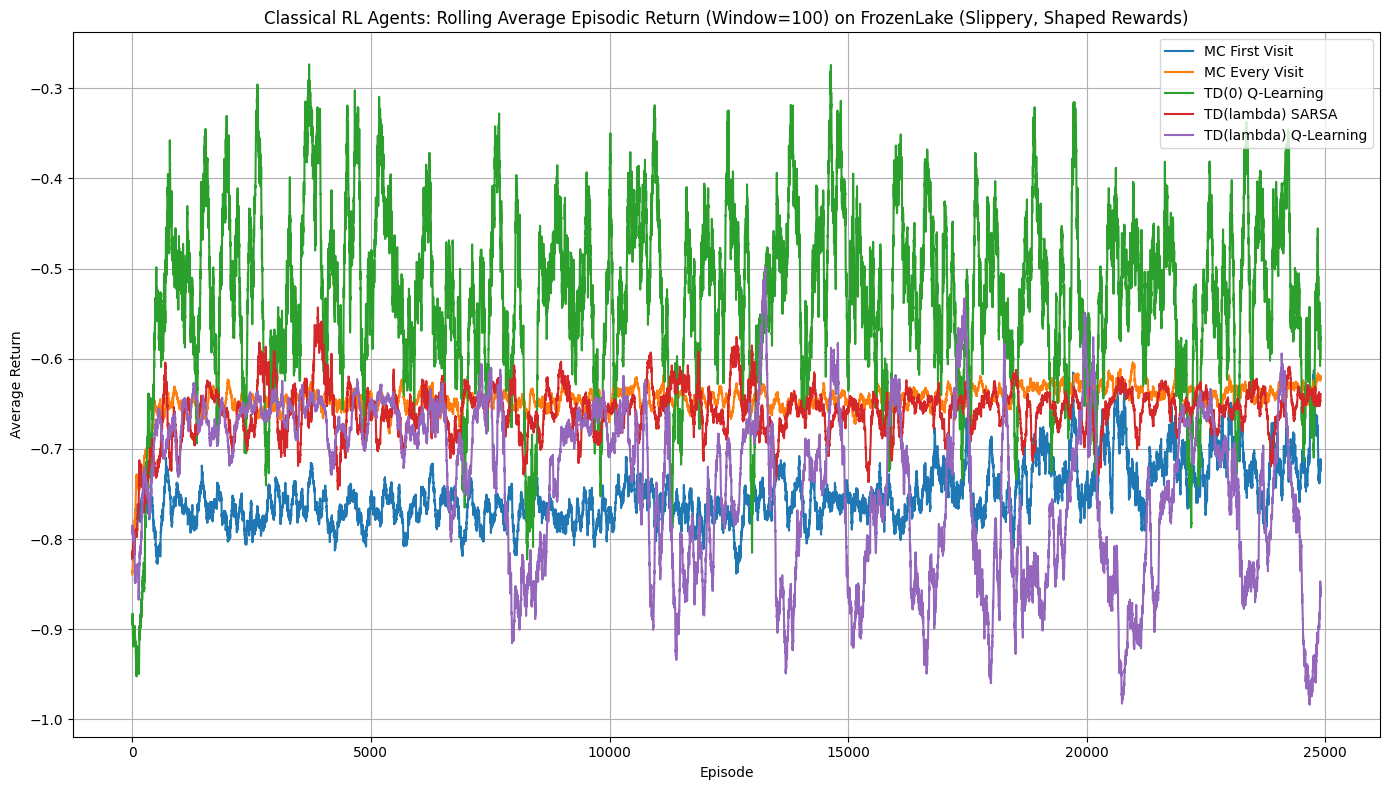

In [7]:
# ==============================================================================
# === HELPER FUNCTIONS ===
# ==============================================================================

def plot_metric(metric_values, label, window=100):
    """
    Plots the rolling average of a given metric over episodes.

    Args:
        metric_values (list or np.array): List of metric values per episode (e.g., rewards).
        label (str): Label for the plot line.
        window (int): The size of the rolling window for averaging.
    """
    if len(metric_values) < window:
        # print(f"Warning: Not enough data points ({len(metric_values)}) for a window of {window}. Plotting raw values.")
        plt.plot(metric_values, label=label)
        return

    # Calculate the rolling average using convolution.
    # np.ones(window)/window creates a kernel for averaging.
    # mode='valid' ensures that the output has a size that doesn't include partial windows.
    rolling_avg = np.convolve(metric_values, np.ones(window)/window, mode='valid')
    plt.plot(rolling_avg, label=label)

def evaluate_agent(rewards, times, successes): # Added 'successes'
    """
    Evaluates the performance of an RL agent based on collected rewards, times, and successes.

    Args:
        rewards (list): A list of total rewards obtained in each episode.
        times (list): A list of times taken for each episode.
        successes (list): A list of boolean values indicating success (True) or failure (False) for each episode.

    Returns:
        tuple: A tuple containing:
            - variance (float): Variance of the rewards.
            - sample_eff (int): Sample efficiency (episode number to reach 90% of max rolling avg).
            - avg_time (float): Average time taken per episode.
            - success_rate (float): Overall success rate (proportion of successful episodes).
    """
    rewards_np = np.array(rewards)
    successes_np = np.array(successes) # Convert to numpy array

    # Ensure there's enough data for rolling average, otherwise use mean/variance of available data
    if len(rewards_np) >= 100:
        variance = np.var(rewards_np)
        rolling_avg = np.convolve(rewards_np, np.ones(100)/100, mode='valid')
        max_avg = np.max(rolling_avg)
        sample_eff = next((i for i, avg in enumerate(rolling_avg) if avg >= 0.9 * max_avg), -1)
    elif len(rewards_np) > 1: # For fewer than 100 episodes but more than 1
        variance = np.var(rewards_np)
        sample_eff = -1 # Cannot determine meaningful sample efficiency
        max_avg = np.mean(rewards_np) # Use mean of all rewards
    else: # 0 or 1 episode
        variance = 0.0
        sample_eff = -1
        max_avg = 0.0 # Or some appropriate default for rewards.

    avg_time = np.mean(times) if len(times) > 0 else 0.0
    success_rate = np.mean(successes_np) if len(successes_np) > 0 else 0.0
    return variance, sample_eff, avg_time, success_rate


# ==============================================================================
# === ENVIRONMENT WRAPPERS ===
# ==============================================================================

class ShapedFrozenLakeWrapper(gym.Wrapper):
    """
    A custom Gymnasium wrapper for the FrozenLake environment that modifies the reward structure.
    It introduces shaped rewards to guide the agent's learning process,
    penalizing steps and falls into holes, and rewarding reaching the goal.
    """
    def __init__(self, env):
        """
        Initializes the wrapper with the base environment.

        Args:
            env (gym.Env): The base FrozenLake environment.
        """
        super().__init__(env)

    def step(self, action):
        """
        Performs a step in the environment and applies reward shaping.

        Args:
            action (int): The action taken by the agent.

        Returns:
            tuple: (obs, shaped_reward, terminated, truncated, info)
                   - obs (object): The new observation of the environment.
                   - shaped_reward (float): The modified reward.
                   - terminated (bool): Whether the episode has ended due to termination.
                   - truncated (bool): Whether the episode has ended due to truncation.
                   - info (dict): Additional information from the environment.
        """
        obs, reward, terminated, truncated, info = self.env.step(action)

        # Start with a small negative reward per step to encourage shorter paths
        shaped_reward = -0.01
        
        # Get the current tile type to determine specific reward shaping
        # This assumes a FrozenLake environment with `unwrapped.desc` and `unwrapped.s`
        try:
            desc = self.unwrapped.desc.tolist()
            row, col = self.unwrapped.s // self.unwrapped.ncol, self.unwrapped.s % self.unwrapped.ncol
            current_tile = desc[row][col].decode("utf-8")
        except AttributeError:
            # Fallback for environments that might not have these attributes or if unwrapped fails
            current_tile = '' # Cannot determine tile type without specific env attributes

        # Check what happened at the end of the episode
        if terminated:
            if reward == 1.0: # Original environment's goal reward
                shaped_reward = 1.0  # High reward for reaching the goal
            elif current_tile == 'H':
                shaped_reward = -0.5  # Significant penalty for falling in a hole
            elif 'is_success' in info and not info['is_success']:
                # Generic check for failure in terminated state if no 'H'
                shaped_reward = -0.5 # General penalty for failing to reach goal when terminated
        # else: shaped_reward remains -0.01 per step

        return obs, shaped_reward, terminated, truncated, info

# ==============================================================================
# === CLASSICAL TABULAR RL AGENTS ===
# ==============================================================================

def mc_first_visit(env, episodes=5000, gamma=0.99, epsilon=0.1):
    """
    Implements the Monte Carlo First-Visit Control algorithm.

    Args:
        env (gym.Env): The Gymnasium environment.
        episodes (int): The total number of episodes to train for.
        gamma (float): Discount factor.
        epsilon (float): Epsilon for epsilon-greedy policy.

    Returns:
        tuple: A tuple containing:
            - Q (defaultdict): The learned Q-value function.
            - rewards_per_episode (list): Total rewards obtained in each episode.
            - times_per_episode (list): Time taken for each episode.
            - successes_per_episode (list): Boolean list indicating success for each episode.
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    returns = defaultdict(list)
    rewards_per_episode = []
    times_per_episode = []
    successes_per_episode = [] # New list to store success per episode

    for _ in tqdm(range(episodes), desc="MC First Visit"):
        start = time.time()
        state, info = env.reset() # Capture info on reset
        episode = []
        done = False
        episode_success = False # Flag for current episode's success

        while not done:
            action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[state])
            next_state, reward, terminated, truncated, info = env.step(action)
            episode.append((state, action, reward))
            state = next_state
            done = terminated or truncated
            if terminated and info.get('is_success', False): # Check for success
                episode_success = True

        G = 0
        visited = set()
        
        for s, a, r in reversed(episode):
            G = gamma * G + r
            if (s, a) not in visited:
                visited.add((s, a))
                returns[(s, a)].append(G)
                Q[s][a] = np.mean(returns[(s, a)])

        rewards_per_episode.append(sum([x[2] for x in episode]))
        times_per_episode.append(time.time() - start)
        successes_per_episode.append(episode_success) # Store success

    return Q, rewards_per_episode, times_per_episode, successes_per_episode

def mc_every_visit(env, episodes=5000, gamma=0.99, epsilon=0.1):
    """
    Implements the Monte Carlo Every-Visit Control algorithm.

    Args:
        env (gym.Env): The Gymnasium environment.
        episodes (int): The total number of episodes to train for.
        gamma (float): Discount factor.
        epsilon (float): Epsilon for epsilon-greedy policy.

    Returns:
        tuple: A tuple containing:
            - Q (defaultdict): The learned Q-value function.
            - rewards_per_episode (list): Total rewards obtained in each episode.
            - times_per_episode (list): Time taken for each episode.
            - successes_per_episode (list): Boolean list indicating success for each episode.
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    returns = defaultdict(list)
    rewards_per_episode = []
    times_per_episode = []
    successes_per_episode = []

    for _ in tqdm(range(episodes), desc="MC Every Visit"):
        start = time.time()
        state, info = env.reset() # Capture info on reset
        episode = []
        done = False
        episode_success = False

        while not done:
            action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[state])
            next_state, reward, terminated, truncated, info = env.step(action)
            episode.append((state, action, reward))
            state = next_state
            done = terminated or truncated
            if terminated and info.get('is_success', False): # Check for success
                episode_success = True

        G = 0
        for i in reversed(range(len(episode))):
            s, a, r = episode[i]
            G = gamma * G + r
            returns[(s, a)].append(G)
            Q[s][a] = np.mean(returns[(s, a)])

        rewards_per_episode.append(sum([x[2] for x in episode]))
        times_per_episode.append(time.time() - start)
        successes_per_episode.append(episode_success)

    return Q, rewards_per_episode, times_per_episode, successes_per_episode

def td0_q_learning(env, episodes=5000, gamma=0.99, alpha=0.1, epsilon=0.1):
    """
    Implements the TD(0) Q-Learning algorithm.

    Args:
        env (gym.Env): The Gymnasium environment.
        episodes (int): The total number of episodes to train for.
        gamma (float): Discount factor.
        alpha (float): Learning rate.
        epsilon (float): Epsilon for epsilon-greedy policy.

    Returns:
        tuple: A tuple containing:
            - Q (defaultdict): The learned Q-value function.
            - rewards_per_episode (list): Total rewards obtained in each episode.
            - times_per_episode (list): Time taken for each episode.
            - successes_per_episode (list): Boolean list indicating success for each episode.
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards_per_episode = []
    times_per_episode = []
    successes_per_episode = []

    for _ in tqdm(range(episodes), desc="TD(0) Q-Learning"):
        start = time.time()
        state, info = env.reset() # Capture info on reset
        total_reward = 0
        done = False
        episode_success = False

        while not done:
            action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[state])
            next_state, reward, terminated, truncated, info = env.step(action)
            
            max_q_next = np.max(Q[next_state]) 
            Q[state][action] += alpha * (reward + gamma * max_q_next - Q[state][action])
            
            state = next_state
            total_reward += reward
            done = terminated or truncated
            if terminated and info.get('is_success', False): # Check for success
                episode_success = True

        rewards_per_episode.append(total_reward)
        times_per_episode.append(time.time() - start)
        successes_per_episode.append(episode_success)

    return Q, rewards_per_episode, times_per_episode, successes_per_episode

def td_lambda_sarsa(env, episodes=5000, gamma=0.99, alpha=0.1, lam=0.9, epsilon=0.1):
    """
    Implements the TD(lambda) SARSA algorithm with eligibility traces.

    Args:
        env (gym.Env): The Gymnasium environment.
        episodes (int): The total number of episodes to train for.
        gamma (float): Discount factor.
        alpha (float): Learning rate.
        lam (float): Lambda parameter for eligibility traces.
        epsilon (float): Epsilon for epsilon-greedy policy.

    Returns:
        tuple: A tuple containing:
            - Q (defaultdict): The learned Q-value function.
            - rewards_per_episode (list): Total rewards obtained in each episode.
            - times_per_episode (list): Time taken for each episode.
            - successes_per_episode (list): Boolean list indicating success for each episode.
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards_per_episode = []
    times_per_episode = []
    successes_per_episode = []

    # Clipping values to prevent overflow
    CLIP_VALUE_Q = 100.0 # Can be higher than TD(lambda) Q-Learning since it's on-policy
    CLIP_VALUE_E = 100.0

    for _ in tqdm(range(episodes), desc="TD(lambda) SARSA"):
        start = time.time()
        state, info = env.reset() # Capture info on reset
        action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[state])
        
        E = defaultdict(lambda: np.zeros(env.action_space.n))  
        total_reward = 0
        done = False
        episode_success = False

        while not done:
            next_state, reward, terminated, truncated, info = env.step(action)
            next_action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[next_state])
            
            delta = reward + gamma * Q[next_state][next_action] - Q[state][action]
            
            E[state][action] += 1
            E[state][action] = np.clip(E[state][action], -CLIP_VALUE_E, CLIP_VALUE_E) # Clip E after increment
            
            for s in Q:
                for a in range(env.action_space.n):
                    Q[s][a] += alpha * delta * E[s][a]
                    Q[s][a] = np.clip(Q[s][a], -CLIP_VALUE_Q, CLIP_VALUE_Q) # Clip Q-values
                    E[s][a] *= gamma * lam
                    E[s][a] = np.clip(E[s][a], -CLIP_VALUE_E, CLIP_VALUE_E) # Clip E after decay
            
            state = next_state
            action = next_action
            total_reward += reward
            done = terminated or truncated
            if terminated and info.get('is_success', False): # Check for success
                episode_success = True

        rewards_per_episode.append(total_reward)
        times_per_episode.append(time.time() - start)
        successes_per_episode.append(episode_success)

    return Q, rewards_per_episode, times_per_episode, successes_per_episode

def td_lambda_q_learning(env, episodes=5000, gamma=0.99, alpha=0.1, lam=0.9, epsilon=0.1):
    """
    Implements the TD(lambda) Q-Learning algorithm with eligibility traces.

    Args:
        env (gym.Env): The Gymnasium environment.
        episodes (int): The total number of episodes to train for.
        gamma (float): Discount factor.
        alpha (float): Learning rate.
        lam (float): Lambda parameter for eligibility traces.
        epsilon (float): Epsilon for epsilon-greedy policy.

    Returns:
        tuple: A tuple containing:
            - Q (defaultdict): The learned Q-value function.
            - rewards_per_episode (list): Total rewards obtained in each episode.
            - times_per_episode (list): Time taken for each episode.
            - successes_per_episode (list): Boolean list indicating success for each episode.
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards_per_episode = []
    times_per_episode = []
    successes_per_episode = []

    # Clipping values to prevent overflow
    CLIP_VALUE_Q = 10.0 # Max reward is 1.0, so Q-values shouldn't get too high
    CLIP_VALUE_E = 100.0 # Eligibility traces can grow large

    for _ in tqdm(range(episodes), desc="TD(lambda) Q-Learning"):
        start = time.time()
        state, info = env.reset() # Capture info on reset
        E = defaultdict(lambda: np.zeros(env.action_space.n))  
        total_reward = 0
        done = False
        episode_success = False

        while not done:
            action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[state])
            next_state, reward, terminated, truncated, info = env.step(action)
            
            max_q_next = np.max(Q[next_state]) 
            delta = reward + gamma * max_q_next - Q[state][action]
            
            E[state][action] += 1
            E[state][action] = np.clip(E[state][action], -CLIP_VALUE_E, CLIP_VALUE_E) # Clip E after increment
            
            for s in Q: # Iterate through all known states in Q
                for a in range(env.action_space.n):
                    Q[s][a] += alpha * delta * E[s][a]
                    Q[s][a] = np.clip(Q[s][a], -CLIP_VALUE_Q, CLIP_VALUE_Q) # Clip Q-values
                    E[s][a] *= gamma * lam  # Decay eligibility trace.
                    E[s][a] = np.clip(E[s][a], -CLIP_VALUE_E, CLIP_VALUE_E) # Clip E after decay
            
            state = next_state
            total_reward += reward
            done = terminated or truncated
            if terminated and info.get('is_success', False): # Check for success
                episode_success = True

        rewards_per_episode.append(total_reward)
        times_per_episode.append(time.time() - start)
        successes_per_episode.append(episode_success)

    return Q, rewards_per_episode, times_per_episode, successes_per_episode

# ==============================================================================
# === DEEP REINFORCEMENT LEARNING AGENTS (DDQN) ===
# ==============================================================================

class DDQN(nn.Module):
    """
    The Deep Q-Network (DQN) architecture.
    It's a simple feed-forward neural network that takes a state as input
    and outputs Q-values for each possible action.
    """
    def __init__(self, state_dim, action_dim):
        """
        Initializes the DDQN neural network.

        Args:
            state_dim (int): The dimension of the input state.
            action_dim (int): The number of possible actions (output dimension).
        """
        super().__init__()
        # Define a sequential neural network with one hidden layer.
        self.net = nn.Sequential(
            nn.Linear(state_dim, 64),  # Input layer to hidden layer
            nn.ReLU(),                 # ReLU activation function
            nn.Linear(64, action_dim)  # Hidden layer to output layer (Q-values for each action)
        )

    def forward(self, x):
        """
        Performs a forward pass through the network.

        Args:
            x (torch.Tensor): The input state tensor.
                               Expected to be one-hot encoded for discrete states.
        Returns:
            torch.Tensor: The output Q-values for each action.
        """
        return self.net(x)

class DDQNAgent:
    """
    Implements a Double Deep Q-Network (DDQN) agent.
    DDQN uses two neural networks (Q-network and Target network) to stabilize training,
    and incorporates experience replay and epsilon-greedy exploration.
    """
    def __init__(self, env, gamma=0.99, lr=1e-3, memory_capacity=10000, batch_size=32, update_freq=50):
        """
        Initializes the DDQN Agent.

        Args:
            env (gym.Env): The environment the agent will interact with.
            gamma (float): Discount factor for future rewards.
            lr (float): Learning rate for the optimizer.
            memory_capacity (int): Maximum size of the experience replay memory.
            batch_size (int): Number of transitions to sample for each learning step.
            update_freq (int): How often to update the target network (every 'update_freq' learning steps).
        """
        self.env = env
        self.gamma = gamma
        self.epsilon = 1.0  # Initial exploration rate
        self.epsilon_decay = 0.9998  # Rate at which epsilon decays (adjusted for 8x8 deterministic)
        self.epsilon_min = 0.01     # Minimum exploration rate (adjusted for 8x8 deterministic)
        
        # Determine the device (CPU or GPU) for PyTorch operations
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # State_dim now equals observation_space.n for one-hot encoding
        state_dim = env.observation_space.n 
        action_dim = env.action_space.n

        # Main Q-network: used for action selection and learning
        self.q_net = DDQN(state_dim, action_dim).to(self.device)
        # Target Q-network: a copy of the Q-network used to compute target Q-values
        # This helps stabilize training by providing a fixed target for some time.
        self.target_net = DDQN(state_dim, action_dim).to(self.device)
        # Initialize target network with the same weights as the main Q-network
        self.target_net.load_state_dict(self.q_net.state_dict())

        # Optimizer for updating Q-network weights
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        # Loss function for computing the difference between predicted and target Q-values
        self.criteria = nn.MSELoss() # Mean Squared Error Loss

        # Experience replay buffer: stores (state, action, reward, next_state, done) transitions
        self.memory = []
        self.memory_capacity = memory_capacity
        self.batch_size = batch_size
        self.update_freq = update_freq
        self.learn_step = 0   # Counter for learning steps

    def _state_to_tensor(self, state):
        """Converts a discrete state integer to a one-hot encoded tensor."""
        state_one_hot = torch.zeros(self.env.observation_space.n, dtype=torch.float32)
        state_one_hot[state] = 1.0
        return state_one_hot.unsqueeze(0).to(self.device) # Add batch dimension

    def act(self, state):
        """
        Selects an action using an epsilon-greedy policy.

        Args:
            state (int): The current state observation (an integer in FrozenLake).

        Returns:
            int: The chosen action.
        """
        # Epsilon-greedy action selection:
        # With probability epsilon, choose a random action (exploration).
        # Otherwise, choose the action with the highest Q-value from the Q-network (exploitation).
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        
        # Convert state to a PyTorch one-hot tensor
        state_tensor = self._state_to_tensor(state)
        
        # Disable gradient calculation for action selection (inference only).
        self.q_net.eval() # Set Q-network to evaluation mode (e.g., disables dropout)
        with torch.no_grad():
            # Get Q-values from the Q-network and select the action with the maximum Q-value.
            q_values = self.q_net(state_tensor)
        self.q_net.train() # Set Q-network back to training mode
        return torch.argmax(q_values).item()

    def remember(self, transition):
        """
        Stores a new transition in the experience replay memory.

        Args:
            transition (tuple): A tuple (state, action, reward, next_state, done).
        """
        self.memory.append(transition)
        # Limit the memory size to avoid excessive memory usage.
        if len(self.memory) > self.memory_capacity:
            self.memory.pop(0) # Remove the oldest transition if memory is full.

    def learn(self):
        """
        Performs one learning step using a batch of experiences from the replay memory.
        This involves computing the TD target, calculating the loss, and updating the Q-network.
        It also periodically updates the target network and decays epsilon.
        """
        # Do not learn if there aren't enough samples in memory for a full batch.
        if len(self.memory) < self.batch_size:
            return

        # Sample a random batch of transitions from the replay memory.
        batch = random.sample(self.memory, self.batch_size)
        # Unzip the batch into separate lists for states, actions, rewards, next_states, and dones.
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert lists of states/next_states to one-hot tensors, and others to appropriate tensors
        states = torch.cat([self._state_to_tensor(s) for s in states]).to(self.device)
        next_states = torch.cat([self._state_to_tensor(s) for s in next_states]).to(self.device)
        
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(self.device)
        # 'dones' indicates if a state is terminal, so its Q-value should be 0.
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(self.device)

        # Compute Q-values predicted by the main Q-network for the taken actions.
        # .gather(1, actions) selects the Q-value for the specific action taken in each state.
        q_values = self.q_net(states).gather(1, actions)
        
        # Compute the target Q-values for the Double DQN algorithm.
        # It uses the main Q-network to select the best action in the next state (maximizes Q).
        # Then, it uses the target network to evaluate the Q-value of that selected action.
        # The `max(1)[1]` returns the indices of the max values.
        # `q_net(next_states).max(1)[1].unsqueeze(1)` selects the best action for next_states
        # `target_net(next_states).gather(1, ...)` gets the Q-value of that action from the target net.
        next_state_actions = self.q_net(next_states).max(1)[1].unsqueeze(1) # Action chosen by Q-net for next state
        next_q_target = self.target_net(next_states).gather(1, next_state_actions).detach() # Q-value from target net

        # The Q-learning target: R + gamma * Q_target(S', argmax_a Q_main(S', a))
        # (1 - dones) handles terminal states: if done, the future reward term is zero.
        q_target = rewards + (1 - dones) * self.gamma * next_q_target

        # Calculate the Mean Squared Error loss between the predicted Q-values and the target Q-values.
        loss = self.criteria(q_values, q_target)
        
        # Zero the gradients, perform backpropagation, and update the Q-network weights.
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Periodically update the target network by copying the weights from the main Q-network.
        self.learn_step += 1
        if self.learn_step % self.update_freq == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())

        # Decay epsilon to reduce exploration over time.
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

# ==============================================================================
# === GENERAL TRAINING LOOP ===
# ==============================================================================

def train_agent(env, agent, episodes=5000):
    """
    General training loop for an RL agent. This function is designed to work
    with both tabular agents (which might have their own integrated training logic
    if passed directly) and DDQNAgent (which uses remember/learn methods).

    Args:
        env (gym.Env): The environment to train in.
        agent (callable or DDQNAgent): If callable (like MC/TD functions), it's called directly.
                                        If DDQNAgent, its act/remember/learn methods are used.
        episodes (int): The number of episodes to run for training.

    Returns:
        tuple: (rewards_per_episode, times_per_episode, successes_per_episode)
               - rewards_per_episode (list): A list of total rewards obtained in each episode.
               - times_per_episode (list): A list of times taken for each episode.
               - successes_per_episode (list): A list of booleans indicating if an episode was successful.
    """
    if isinstance(agent, DDQNAgent):
        # Specific training logic for DDQNAgent (using its act/remember/learn methods)
        rewards_per_episode = [] 
        times_per_episode = []
        successes_per_episode = [] # Initialize for DDQN
        for ep in tqdm(range(episodes), desc=f"Training DDQN Agent"):
            start_time = time.time()
            state, info = env.reset() # Capture info from reset
            total_reward = 0
            done = False
            episode_success = False # Flag for current episode's success

            while not done:
                action = agent.act(state)
                next_state, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated

                agent.remember((state, action, reward, next_state, done))
                agent.learn() # DDQN agent learns from a batch.

                total_reward += reward
                state = next_state
                
                if terminated and info.get('is_success', False): # Check for success
                    episode_success = True
            
            rewards_per_episode.append(total_reward)
            times_per_episode.append(time.time() - start_time)
            successes_per_episode.append(episode_success) # Store success for this episode
        return rewards_per_episode, times_per_episode, successes_per_episode

    else:
        # Assumes `agent` is a function (like mc_first_visit, td0_q_learning)
        # that encapsulates its own training loop and returns Q, rewards, times, successes.
        Q_table, rewards_per_episode, times_per_episode, successes_per_episode = agent(env, episodes=episodes)
        return rewards_per_episode, times_per_episode, successes_per_episode

# ==============================================================================
# === MAIN EXECUTION FOR ALL FROZENLAKE AGENTS ===
# ==============================================================================

if __name__ == "__main__":
    
    # --- IMPORTANT: Ensure gymnasium is installed ---
    try:
        import gymnasium as gym
    except ImportError:
        print("Error: 'gymnasium' not found.")
        print("Please install it using: pip install gymnasium")
        # For FrozenLake specifically: pip install gymnasium[toy-text]
        # Or for full install: pip install gymnasium[all]
        exit()

    # --- Configuration for DDQN Agent ---
    plt.figure(figsize=(10, 6)) # New figure for DDQN
    print("\n--- Training DDQN Agent with Shaped Rewards (Deterministic Environment) ---")
    
    # DDQN env: Deterministic with shaped rewards
    ddqn_base_env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False, render_mode=None)
    ddqn_env = ShapedFrozenLakeWrapper(ddqn_base_env)
    
    # Adjusted episodes for DDQN training
    ddqn_agent = DDQNAgent(ddqn_env, lr=5e-4, memory_capacity=20000, batch_size=64, update_freq=100) 
    ddqn_rewards, ddqn_times, ddqn_successes = train_agent(ddqn_env, ddqn_agent, episodes=25000) # Increased episodes
    
    ddqn_var, ddqn_eff, ddqn_avg_time, ddqn_success_rate = evaluate_agent(ddqn_rewards, ddqn_times, ddqn_successes)
    plot_metric(ddqn_rewards, "DDQN") 
    plt.title("DDQN Rolling Average Episodic Return (Window=100) on FrozenLake (Deterministic, Shaped)")
    plt.xlabel("Episode")
    plt.ylabel("Average Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('ddqn_rolling_average.png') # Save the DDQN plot
    plt.show() 

    print(f"\nDDQN Results (Deterministic, Shaped):\n  Variance: {ddqn_var:.4f}, Sample Efficiency (90% peak avg): {ddqn_eff} episodes, Time/Episode: {ddqn_avg_time:.4f}s, Success Rate: {ddqn_success_rate:.2%}")
    ddqn_env.close()

    # --- Configuration for Classical Tabular RL Agents ---
    plt.figure(figsize=(14, 8)) # New figure for classical agents
    print("\n--- Training Classical TD and Monte Carlo Agents on Slippery FrozenLake with Shaped Rewards ---")
    
    # Classical env: Slippery with shaped rewards (CRITICAL CORRECTION HERE)
    classic_base_env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=True, render_mode=None)
    classic_env = ShapedFrozenLakeWrapper(classic_base_env) # <<< ENSURE THIS IS WRAPPED

    # Increased episodes for classical agents
    classical_agents_configs = [
        ("MC First Visit", mc_first_visit, 25000), 
        ("MC Every Visit", mc_every_visit, 25000),
        ("TD(0) Q-Learning", td0_q_learning, 25000),
        ("TD(lambda) SARSA", td_lambda_sarsa, 25000),
        ("TD(lambda) Q-Learning", td_lambda_q_learning, 25000)
    ]

    for name, agent_func, episodes_to_run in classical_agents_configs:
        Q_table, rewards, times, successes = agent_func(classic_env, episodes=episodes_to_run) # Capture successes
        
        var, eff, avg_time, success_rate = evaluate_agent(rewards, times, successes) # Pass successes to evaluate
        plot_metric(rewards, name)
        print(f"\n{name} Results (Slippery, Shaped Rewards):\n  Variance: {var:.4f}, Sample Efficiency (90% peak avg): {eff} episodes, Time/Episode: {avg_time:.4f}s, Success Rate: {success_rate:.2%}")
    
    plt.title("Classical RL Agents: Rolling Average Episodic Return (Window=100) on FrozenLake (Slippery, Shaped Rewards)")
    plt.xlabel("Episode")
    plt.ylabel("Average Return")
    plt.legend()  
    plt.grid(True) 
    plt.tight_layout() 
    plt.savefig('classical_agents_rolling_average.png') # Save the classical agents plot
    plt.show() 

    classic_env.close()

- **Observation**: None of the agents ever reached the goal state across 25000 episodes, inspite of shaped rewards and longer training.
- **Further actions**:
    - Test with is-slippery=False to reduce environment randomness and check if agents are learning
    - Track raw returns and Success Episodes
    - Use more aggressive exploration at the beginning

#### Bandit Environment for Simulating a Multi-Armed Bandit

GreedyStrategy: 100%|██████████| 1000/1000 [00:00<00:00, 155011.60it/s]


Greedy Final Cumulative Reward: 1022.86, Optimal Action %: 0.00%


EpsilonGreedyStrategy: 100%|██████████| 1000/1000 [00:00<00:00, 160020.75it/s]


Epsilon Greedy Final Cumulative Reward: 2745.42, Optimal Action %: 72.70%


DecayingEpsilonGreedyStrategy: 100%|██████████| 1000/1000 [00:00<00:00, 239114.30it/s]


Decaying Epsilon Greedy Final Cumulative Reward: 1948.01, Optimal Action %: 0.00%


UCBStrategy: 100%|██████████| 1000/1000 [00:00<00:00, 49228.92it/s]


UCB Final Cumulative Reward: 2837.78, Optimal Action %: 91.50%


ThompsonSamplingStrategy: 100%|██████████| 1000/1000 [00:00<00:00, 32989.13it/s]


Thompson Sampling Final Cumulative Reward: 2868.00, Optimal Action %: 85.80%


PolicyGradientStrategy: 100%|██████████| 1000/1000 [00:00<00:00, 29993.81it/s]


Policy Gradient Final Cumulative Reward: 2881.08, Optimal Action %: 92.90%


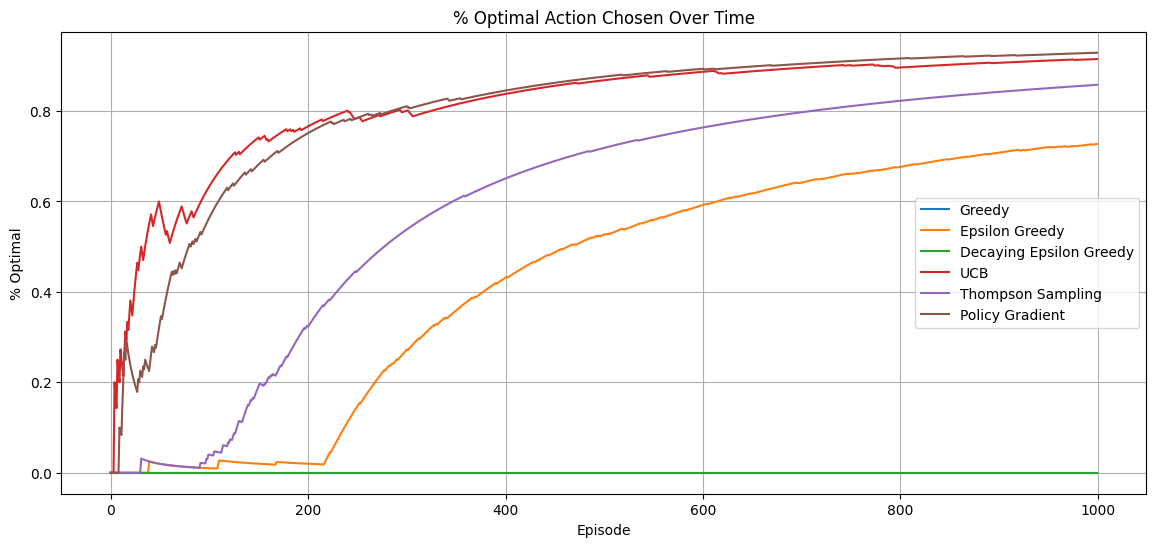

In [5]:
# === BANDIT ENVIRONMENT ===
class MultiArmedBanditEnv(gym.Env):
    """
    A custom Gymnasium environment for simulating a Multi-Armed Bandit (MAB) problem.
    In an MAB, there is a single state, and the agent chooses an "arm" (action)
    to receive a reward, with the goal of maximizing cumulative reward over time.
    Each arm has a reward distribution (here, Gaussian).
    """
    def __init__(self, n_arms, means, stds):
        """
        Initializes the Multi-Armed Bandit environment.

        Args:
            n_arms (int): The total number of arms (actions) available.
            means (list): A list of mean rewards for each arm.
            stds (list): A list of standard deviations for the rewards of each arm.
                         Should be of the same length as `means`.
        """
        super(MultiArmedBanditEnv, self).__init__()
        self.n_arms = n_arms
        self.means = means
        self.stds = stds
        
        # Define the action space as discrete, corresponding to the number of arms.
        self.action_space = gym.spaces.Discrete(n_arms)
        
        # Define the observation space as discrete with a single state (0),
        # as bandit problems typically have no changing state.
        self.observation_space = gym.spaces.Discrete(1)

    def reset(self):
        """
        Resets the environment. For a bandit problem, this typically means
        returning to the single initial state.

        Returns:
            int: The initial observation (always 0 for a bandit).
        """
        return 0

    def step(self, action):
        """
        Performs a step in the environment by "pulling" a specific arm.

        Args:
            action (int): The index of the arm to pull.

        Returns:
            tuple: (observation, reward, terminated, truncated, info)
                   - observation (int): The next observation (always 0).
                   - reward (float): The reward obtained from pulling the selected arm.
                   - terminated (bool): Always True, as a single pull concludes the "episode" for a bandit.
                   - truncated (bool): Always False in this context.
                   - info (dict): An empty dictionary for additional information.
        """
        # Generate a reward from a normal distribution based on the chosen arm's mean and std.
        reward = np.random.normal(self.means[action], self.stds[action])
        
        # For a bandit, each step is typically considered the end of an "episode" or trial.
        # The next observation is always the same "state" 0.
        return 0, reward, True, {} # obs, reward, terminated, truncated, info

# === BANDIT AGENTS ===
def run_bandit_agent(env, strategy_fn, episodes=1000):
    """
    Runs a simulation for a given bandit strategy in the specified environment.

    Args:
        env (MultiArmedBanditEnv): The bandit environment instance.
        strategy_fn (callable): A function that, when called with `env.n_arms`,
                                returns an initialized bandit strategy object.
        episodes (int): The total number of times to pull an arm (trials).

    Returns:
        tuple: (rewards, optimal_counts)
               - rewards (list): A list of rewards obtained in each episode.
               - optimal_counts (list): A list where each element is 1 if the
                                        optimal arm was chosen in that episode, else 0.
    """
    rewards = []
    optimal_counts = []
    
    # Determine the truly optimal arm based on the environment's means.
    best_arm = np.argmax(env.means)
    
    # Instantiate the chosen bandit strategy.
    strategy = strategy_fn(env.n_arms)

    # Loop through the specified number of episodes (arm pulls).
    for _ in tqdm(range(episodes), desc=type(strategy).__name__):
        # The strategy selects an action (which arm to pull).
        action = strategy.select_action()
        
        # The environment returns a reward for the chosen action.
        # For bandits, the observation is constant and terminated is always True.
        _, reward, _, _ = env.step(action)
        
        # The strategy updates its internal estimates based on the observed reward.
        strategy.update(action, reward)
        
        # Store the received reward.
        rewards.append(reward)
        
        # Check if the chosen action was the optimal arm and record.
        optimal_counts.append(1 if action == best_arm else 0)

    return rewards, optimal_counts

# === Strategy Classes ===
# Each class below implements a different strategy for the Multi-Armed Bandit problem.
# All strategies must implement `select_action()` and `update(arm, reward)`.

class GreedyStrategy:
    """
    Implements a purely greedy strategy. It always selects the arm that
    has yielded the highest average reward so far. This strategy focuses
    solely on exploitation and does not explore.
    """
    def __init__(self, n_arms):
        """
        Initializes the GreedyStrategy.

        Args:
            n_arms (int): The total number of arms.
        """
        self.n = np.zeros(n_arms)    # Count of times each arm has been pulled
        self.values = np.zeros(n_arms) # Estimated average reward for each arm

    def select_action(self):
        """
        Selects an action (arm) greedily based on current value estimates.

        Returns:
            int: The index of the selected arm.
        """
        # If all values are 0 (no pulls yet for any arm), argmax returns 0.
        # This implicitly picks the first arm if no information is available.
        return np.argmax(self.values)

    def update(self, arm, reward):
        """
        Updates the estimated value of the pulled arm using a simple running average.

        Args:
            arm (int): The index of the arm that was pulled.
            reward (float): The reward received from pulling the arm.
        """
        self.n[arm] += 1
        # Incremental update rule: new_average = old_average + (new_value - old_average) / count
        self.values[arm] += (reward - self.values[arm]) / self.n[arm]

class EpsilonGreedyStrategy:
    """
    Implements the Epsilon-Greedy strategy. With probability `epsilon`, it
    chooses a random arm (exploration); otherwise, it chooses the arm
    with the highest estimated value (exploitation).
    """
    def __init__(self, n_arms, epsilon=0.1):
        """
        Initializes the EpsilonGreedyStrategy.

        Args:
            n_arms (int): The total number of arms.
            epsilon (float): The probability of choosing a random action (exploration rate).
        """
        self.n = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
        self.epsilon = epsilon

    def select_action(self):
        """
        Selects an action using an epsilon-greedy approach.

        Returns:
            int: The index of the selected arm.
        """
        if np.random.rand() < self.epsilon:
            # Explore: choose a random arm.
            return np.random.randint(len(self.n))
        # Exploit: choose the arm with the highest estimated value.
        return np.argmax(self.values)

    def update(self, arm, reward):
        """
        Updates the estimated value of the pulled arm.

        Args:
            arm (int): The index of the arm that was pulled.
            reward (float): The reward received.
        """
        self.n[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.n[arm]

class DecayingEpsilonGreedyStrategy:
    """
    Implements an Epsilon-Greedy strategy where the `epsilon` value
    (probability of exploration) decays over time, typically encouraging
    more exploration early on and more exploitation later.
    Here, epsilon decays as `1 / (1 + total_count)`.
    """
    def __init__(self, n_arms):
        """
        Initializes the DecayingEpsilonGreedyStrategy.

        Args:
            n_arms (int): The total number of arms.
        """
        self.n = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
        self.total_count = 0 # Total number of pulls across all arms

    def select_action(self):
        """
        Selects an action using a decaying epsilon-greedy approach.

        Returns:
            int: The index of the selected arm.
        """
        epsilon = 1 / (1 + self.total_count) # Calculate current epsilon
        self.total_count += 1 # Increment total pulls after calculating epsilon for current step
        if np.random.rand() < epsilon:
            return np.random.randint(len(self.n))
        return np.argmax(self.values)

    def update(self, arm, reward):
        """
        Updates the estimated value of the pulled arm.

        Args:
            arm (int): The index of the arm that was pulled.
            reward (float): The reward received.
        """
        self.n[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.n[arm]

class UCBStrategy:
    """
    Implements the Upper Confidence Bound (UCB) strategy. UCB balances
    exploration and exploitation by selecting the arm that maximizes
    the sum of its estimated value and an exploration bonus. The bonus
    is higher for arms that have been pulled fewer times or for which
    there's higher uncertainty.
    """
    def __init__(self, n_arms, c=2):
        """
        Initializes the UCBStrategy.

        Args:
            n_arms (int): The total number of arms.
            c (float): The exploration parameter, balancing exploitation and exploration.
        """
        self.n = np.zeros(n_arms)    # Count of times each arm has been pulled
        self.values = np.zeros(n_arms) # Estimated average reward for each arm
        self.total = 0               # Total number of times any arm has been pulled
        self.c = c                   # Exploration constant

    def select_action(self):
        """
        Selects an action based on the UCB formula.

        Returns:
            int: The index of the selected arm.
        """
        self.total += 1 # Increment total pulls before calculating UCB values
        
        # Calculate UCB value for each arm.
        # Add a small epsilon (1e-5) to self.n[i] to prevent division by zero
        # for arms not yet pulled, or in the log term if self.total is 0.
        ucb_values = [
            self.values[i] + self.c * np.sqrt(np.log(self.total + 1) / (self.n[i] + 1e-5))
            for i in range(len(self.n))
        ]
        
        # If any arm has not been pulled yet (self.n[i] == 0), its exploration bonus will be
        # effectively infinite (due to the log(self.total)/small_number approaching infinity),
        # making it prioritized for exploration first, before calculating actual UCB for others.
        # This ensures all arms are sampled at least once initially.

        return np.argmax(ucb_values)

    def update(self, arm, reward):
        """
        Updates the estimated value of the pulled arm.

        Args:
            arm (int): The index of the arm that was pulled.
            reward (float): The reward received.
        """
        self.n[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.n[arm]

class ThompsonSamplingStrategy:
    """
    Implements the Thompson Sampling strategy, a Bayesian approach to the
    Multi-Armed Bandit problem. It maintains a probability distribution
    over the true mean reward for each arm (using Beta distribution for binary rewards
    or Gaussian for continuous, though Beta is used here requiring clipped rewards).
    At each step, it samples from these distributions and chooses the arm
    whose sampled value is highest.
    """
    def __init__(self, n_arms):
        """
        Initializes the ThompsonSamplingStrategy.

        Args:
            n_arms (int): The total number of arms.
        """
        # For each arm, alpha represents "successes" and beta represents "failures".
        # Initializing with 1,1 corresponds to a uniform prior (Beta(1,1)).
        self.alpha = np.ones(n_arms)
        self.beta = np.ones(n_arms)

    def select_action(self):
        """
        Selects an action by sampling from the Beta distribution for each arm
        and choosing the arm with the highest sampled value.

        Returns:
            int: The index of the selected arm.
        """
        samples = np.random.beta(self.alpha, self.beta)
        return np.argmax(samples)

    def update(self, arm, reward):
        """
        Updates the alpha and beta parameters for the pulled arm based on the reward.
        This implementation assumes binary rewards (0 or 1) by clipping.

        Args:
            arm (int): The index of the arm that was pulled.
            reward (float): The reward received.
        """
        # Clip reward to ensure it's between 0 and 1, as Beta distribution parameters
        # are typically updated with binary outcomes (success/failure).
        reward = np.clip(reward, 0, 1)  # Ensure valid beta parameters (e.g., for non-binary rewards)
        self.alpha[arm] += reward       # If reward is 1, increment alpha (success)
        self.beta[arm] += 1 - reward    # If reward is 0, increment beta (failure)

class PolicyGradientStrategy:
    """
    Implements a basic Policy Gradient method for Multi-Armed Bandits.
    It directly learns a policy (probability distribution over actions)
    by adjusting "preferences" for each arm based on received rewards.
    """
    def __init__(self, n_arms, alpha=0.1):
        """
        Initializes the PolicyGradientStrategy.

        Args:
            n_arms (int): The total number of arms.
            alpha (float): The learning rate for updating preferences.
        """
        self.n_arms = n_arms
        self.alpha = alpha
        self.preferences = np.zeros(n_arms) # Preferences (logits) for each arm
        self.probs = self._softmax()        # Initial probabilities based on preferences

    def _softmax(self):
        """
        Converts raw preferences (logits) into a probability distribution
        using the softmax function. Prevents numerical overflow by subtracting
        the max preference.

        Returns:
            np.array: A probability distribution over the arms.
        """
        e = np.exp(self.preferences - np.max(self.preferences))
        return e / np.sum(e)

    def select_action(self):
        """
        Selects an action (arm) stochastically based on the current policy
        (probability distribution).

        Returns:
            int: The index of the selected arm.
        """
        self.probs = self._softmax() # Recalculate probabilities
        return np.random.choice(self.n_arms, p=self.probs)

    def update(self, arm, reward):
        """
        Updates the preferences for each arm using a simple policy gradient rule.
        It uses a baseline to reduce variance in updates.

        Args:
            arm (int): The index of the arm that was pulled.
            reward (float): The reward received.
        """
        # Calculate a simple baseline (average of preferences weighted by probabilities)
        # to reduce variance in updates.
        baseline = np.dot(self.probs, self.preferences)
        
        # Update preferences for all arms.
        # The preference for the chosen arm is increased if the reward is higher than baseline.
        # Preferences for unchosen arms are decreased proportionally.
        for a in range(self.n_arms):
            self.preferences[a] += self.alpha * (reward - baseline) * ((1 if a == arm else 0) - self.probs[a])

# === MAIN: Run Bandit Agents ===
if __name__ == "__main__":
    # Set up Bandit Environment
    n_arms = 5 # Number of distinct arms (actions)
    
    # Define the true mean rewards for each arm.
    # Arm 4 (index 4) has the highest mean (3.0), making it the optimal arm.
    means = [1.0, 1.5, 2.0, 2.5, 3.0]
    
    # Define the standard deviation of rewards for each arm.
    stds = [1.0] * n_arms # All arms have a standard deviation of 1.0
    
    # Create an instance of the Multi-Armed Bandit environment.
    bandit_env = MultiArmedBanditEnv(n_arms, means, stds)

    # Define a list of bandit strategies to test.
    # Each tuple contains: (display_name, strategy_constructor_function).
    strategies = [
        ("Greedy", lambda n: GreedyStrategy(n)), # Lambda function to pass n_arms
        ("Epsilon Greedy", lambda n: EpsilonGreedyStrategy(n, 0.1)),
        ("Decaying Epsilon Greedy", DecayingEpsilonGreedyStrategy), # No lambda needed if n_arms is direct arg
        ("UCB", lambda n: UCBStrategy(n, 2)),
        ("Thompson Sampling", ThompsonSamplingStrategy),
        ("Policy Gradient", PolicyGradientStrategy)
    ]

    # Create a figure for plotting the results.
    plt.figure(figsize=(14, 6))
    
    # Iterate through each defined strategy, run it, and plot its performance.
    for name, strategy_fn in strategies:
        # Run the bandit simulation for the current strategy.
        rewards, optimal_actions = run_bandit_agent(bandit_env, strategy_fn)
        
        # Calculate the cumulative reward over time (for potential future plotting/analysis).
        cum_reward = np.cumsum(rewards)
        
        # Calculate the percentage of times the optimal action was chosen over time.
        # This is a good metric for evaluating exploration-exploitation balance.
        percent_optimal = np.cumsum(optimal_actions) / (np.arange(len(optimal_actions)) + 1)
        
        # Plot the percentage of optimal actions over episodes.
        plt.plot(percent_optimal, label=name)
        
        # Print final performance metrics for the current strategy.
        print(f"{name} Final Cumulative Reward: {cum_reward[-1]:.2f}, Optimal Action %: {percent_optimal[-1]*100:.2f}%")

    # === Final Plot Settings ===
    plt.title("% Optimal Action Chosen Over Time") # Title of the plot
    plt.xlabel("Episode")                         # X-axis label
    plt.ylabel("% Optimal")                       # Y-axis label
    plt.legend()                                  # Display the legend for different strategies
    plt.grid()                                    # Add a grid for readability
    plt.show()                                    # Show the generated plot

#### Bandit Strategy Simulation

In [6]:
import os     
import random

# Simulate a Bandit Strategy (e.g., Thompson Sampling)
class SimpleBanditResponder:
    """
    Implements a simple Multi-Armed Bandit (MAB) strategy, specifically
    Thompson Sampling with a Beta-Bernoulli conjugate prior.
    This class learns the effectiveness of different "responses" (arms)
    based on binary feedback (success/failure).
    """
    def __init__(self, responses):
        """
        Initializes the bandit responder.

        Args:
            responses (list): A list of possible textual responses (arms)
                              that the bandit can choose from. Each response
                              corresponds to an "arm" in the bandit problem.
        """
        self.responses = responses
        # Initialize success and failure counts for each arm.
        # Starting with 1,1 for each (alpha=1, beta=1) represents a uniform
        # prior distribution for the success probability of each arm in Thompson Sampling.
        self.success_counts = [1] * len(responses)
        self.failure_counts = [1] * len(responses)

    def select_action(self):
        """
        Selects an action (i.e., a response) using Thompson Sampling.
        For each response, it samples a probability from a Beta distribution
        (parameterized by success and failure counts) and chooses the response
        with the highest sampled probability.

        Returns:
            int: The index of the selected response (action).
        """
        # Generate a sample from a Beta distribution for each arm.
        # The Beta distribution Beta(alpha, beta) is suitable for estimating
        # the probability of success when you have observed 'alpha-1' successes
        # and 'beta-1' failures.
        samples = [random.betavariate(s, f) for s, f in zip(self.success_counts, self.failure_counts)]
        
        # Select the arm (response index) that yielded the highest sample.
        return int(max(range(len(samples)), key=lambda i: samples[i]))

    def update(self, action, reward):
        """
        Updates the success or failure counts for the chosen action based on the reward.
        This updates the parameters of the Beta distribution for the respective arm.

        Args:
            action (int): The index of the response (arm) that was chosen.
            reward (int): The feedback received (1 for success, 0 for failure).
        """
        if reward == 1:
            self.success_counts[action] += 1
        else:
            self.failure_counts[action] += 1

# Sample response strategies for an event (can be replaced with real actions)
# This dictionary defines different sets of pre-defined responses for specific
# "complex" events where a bandit strategy might be beneficial to optimize
# which response is most effective over time.
response_table = {
    "Unrecognized Person Detected": [
        "Unrecognized person at the door. Proceed with caution.",
        "Unknown visitor detected. Do you want to alert security?",
        "Stranger detected. Ignoring for now." # This might be the least effective, but could be tested
    ],
    "Animal Intrusion": [
        "Animal intrusion detected. Stay alert.",
        "Unidentified motion near property. Activating lights.", # More active response
        "Wildlife intrusion. Logging event." # More passive response
    ]
}

# Instantiate a bandit responder for each complex event.
# For each event type defined in `response_table`, a `SimpleBanditResponder`
# is created. This means each event type will independently learn which of its
# associated responses is most "successful."
bandit_agents = {
    event: SimpleBanditResponder(responses)
    for event, responses in response_table.items()
}

# Main handler
def event_handler(event_label):
    """
    This function acts as the central dispatch for detected events.
    It decides whether to use a bandit strategy for a dynamic response
    or a static, predefined response.

    Args:
        event_label (str): A string indicating the type of event detected
                           (e.g., "Fire Alarm Detected", "Unrecognized Person Detected").
    """
    print(f"📡 Event Detected: {event_label}")
    
    # Check if a bandit agent is configured for this specific event type.
    if event_label in bandit_agents:
        agent = bandit_agents[event_label]
        
        # The bandit agent selects the "best" action (response) based on its learning.
        action_idx = agent.select_action()
        response = agent.responses[action_idx]

        # Act: This is where the physical action (e.g., speaking via a speaker) would occur.
        # In a real IoT project, `os.system('say ...')` would execute a text-to-speech command
        # on a system that supports it (like macOS) or interact with a speaker API on the RPi.
        print(f"🔊 Action Taken: {response}")

        # Simulate feedback: In a real system, this would come from user interaction,
        # sensor confirmation (e.g., did the lights turn on?), or manual labeling.
        # Here, it's randomly decided as a 1 (success) or 0 (failure).
        simulated_feedback = random.choice([1, 0])  # Success (1) or failure (0)
        
        # The bandit agent updates its internal counts based on the received feedback.
        agent.update(action_idx, simulated_feedback)
        print(f"📈 Feedback: {'Success' if simulated_feedback else 'Ignored'}")

    else:
        # If no bandit agent is defined for the event, use a static, rule-based response.
        # This covers critical or simple events where dynamic learning might not be necessary
        # or desirable (e.g., immediate evacuation for fire alarm).
        static_responses = {
            "Fire Alarm Detected": "Fire alarm detected! Evacuate immediately.",
            "Glass Breaking Sound": "Possible intrusion detected! Alerting security.",
            "Baby Crying": "Baby crying detected. Notifying guardian.",
            "Doorbell Ringing": "Doorbell detected. Please check the entrance.",
            "Gunshot Detected": "Gunshot detected! Take cover and call emergency services.",
            # Additional static responses for various events:
            "Low Light Detection": "Low visibility detected. Turning on night mode.",
            "Face Mask Violation": "Face mask not detected! Please wear a mask.",
            "Crowd Density Exceeded": "High crowd density detected. Maintain social distancing.",
            "Suspicious Object Detected": "Unattended object detected. Please inspect.",
            "Motion Detected at Night": "Unauthorized movement detected! Security alert triggered."
        }

        # Retrieve the static response; if the event is not in the dictionary, provide a default.
        response = static_responses.get(event_label, "Unknown event detected.")
        print(f"🔊 Action Taken: {response}")

# === DEMO USAGE ===
# These lines simulate incoming events to demonstrate the `event_handler`'s functionality.

# This event has a bandit agent associated with it, so it will use Thompson Sampling
# to select a response and update its learning based on simulated feedback.
event_handler("Unrecognized Person Detected")

# This event has a static rule-based response.
event_handler("Fire Alarm Detected")

# This event also has a bandit agent associated with it.
event_handler("Animal Intrusion")

# Example of another bandit-controlled event.
event_handler("Unrecognized Person Detected") # Run again to see learning effects

# Example of another static event.
event_handler("Baby Crying")

📡 Event Detected: Unrecognized Person Detected
🔊 Action Taken: Stranger detected. Ignoring for now.
📈 Feedback: Success
📡 Event Detected: Fire Alarm Detected
🔊 Action Taken: Fire alarm detected! Evacuate immediately.
📡 Event Detected: Animal Intrusion
🔊 Action Taken: Wildlife intrusion. Logging event.
📈 Feedback: Ignored
📡 Event Detected: Unrecognized Person Detected
🔊 Action Taken: Stranger detected. Ignoring for now.
📈 Feedback: Success
📡 Event Detected: Baby Crying
🔊 Action Taken: Baby crying detected. Notifying guardian.


#### LLM Used: ChatGPT, Gemini and DeepSeek
- First Prompt: I have the following requirements document for an IoT project. How do I build a reinforcement learning code with bandits?
- Last Prompt: Give a one-liner report for the event handler block.